In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata

import palettable
from IPython.display import display

from joblib import parallel_backend

from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from geneset_testing import load_geneset, fishertestbygep, mwtestbygep_ZES

from matplotlib import gridspec

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
import os

adir = '../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
gcs = False
abase = os.path.join(adir, project_name)
abase

results_dir = '../../../../results'


count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [4]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Obtain raw counts subsetted data for cells that passed all QC filters

In [5]:
adat_fn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata = read_adata(adat_fn, gcs=gcs)

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


In [6]:
adata_raw = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)

## Output data for each cell-type to load into R for MAST differential expression testing

In [7]:
adata_raw.obs['Subclustering_reduced'].value_counts()

Th             18174
B              13505
Tc             10282
Mono            6976
Neut            5805
NK              1244
cDC              345
pDC              332
Plasmablast      266
Name: Subclustering_reduced, dtype: int64

In [8]:
pd.crosstab(adata_raw.obs['Subclustering_reduced'], adata_raw.obs['Period'])

Period,Baseline,Early,Late,Mid
Subclustering_reduced,,,,
B,1951,2848,6018,2688
Mono,736,3603,1630,1007
NK,577,123,397,147
Neut,10,371,3772,1652
Plasmablast,42,53,148,23
Tc,1933,2163,3691,2495
Th,2855,4613,7323,3383
cDC,73,189,60,23
pDC,21,78,186,47


In [9]:
dedir = os.path.join(adir, 'DE_Stage')
if not os.path.exists(dedir): os.mkdir(dedir)
    
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [10]:
adata_raw.obs['is_fresh'] = adata_raw.obs['frz_status'].replace({'fresh':1, 'FRZ':0})

In [11]:
adata_raw.raw = adata_raw.copy()

In [12]:
adata_raw = adata_raw[:, ~adata_raw.var['Combined_Blacklist']]

In [17]:
cts = ['Th', 'Tc', 'B', 'NK', 'Mono', 'Neut', 'pDC', 'cDC']
test_periods = ['Early', 'Mid', 'Late']

for ct in cts:
    for test_period in test_periods:
        ind = (adata_raw.obs['Subclustering_reduced']==ct) & (adata_raw.obs['Period'].isin(['Baseline', test_period]))
        adata_ct = adata_raw[ind,:].copy()
        adata_ct.obs['Period_Binary'] = adata_ct.obs['Period'].replace({'Baseline':0, test_period:1})        
        adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
        adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
        sc.pp.filter_genes(adata_ct, min_cells=(.01*adata_ct.shape[0]))
        adata_ct.obs['cngeneson'] =  scale((adata_ct.X>0).sum(axis=1)).reshape(-1)        
        sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
        sc.pp.log1p(adata_ct)
        X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
        X.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'))
        adata_ct.obs.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'))
        adata_ct.var.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv'))

filtered out 9685 genes that are detectedin less than 74.68 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9717 genes that are detectedin less than 62.38 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9813 genes that are detectedin less than 101.78 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9576 genes that are detectedin less than 40.96 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9730 genes that are detectedin less than 44.28 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9422 genes that are detectedin less than 56.24 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9460 genes that are detectedin less than 47.99 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9533 genes that are detectedin less than 46.39 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 9866 genes that are detectedin less than 79.69 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 9509 genes that are detectedin less than 7.0 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 9819 genes that are detectedin less than 7.24 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 9636 genes that are detectedin less than 9.74 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 9150 genes that are detectedin less than 43.39 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 8343 genes that are detectedin less than 17.43 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 8369 genes that are detectedin less than 23.66 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 12766 genes that are detectedin less than 3.81 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 12134 genes that are detectedin less than 16.62 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 11145 genes that are detectedin less than 37.82 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 7454 genes that are detectedin less than 0.99 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 8017 genes that are detectedin less than 0.68 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 8766 genes that are detectedin less than 2.07 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 7823 genes that are detectedin less than 2.62 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 6786 genes that are detectedin less than 0.96 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 8058 genes that are detectedin less than 1.33 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [18]:
ncores =4
testvar = 'Period_Binary'
covars = ['is_fresh_scale', 'cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

for ct in cts:
    for test_period in test_periods:
        exprfn = os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv')
        celldatfn = os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv')
        genedatfn = os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv')
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        cmd = 'Rscript ../../../Code/run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
        print(cmd)
        !{cmd}

Rscript ../../../Code/run_mast.R ../../../../data/InVivo/Seqwell/DE_Stage/genefiles/Th.Early.expression.csv ../../../../data/InVivo/Seqwell/DE_Stage/genefiles/Th.Early.celldata.csv ../../../../data/InVivo/Seqwell/DE_Stage/genefiles/Th.Early.genedata.csv ../../../../data/InVivo/Seqwell/DE_Stage/results/Th.Early.DE.csv 4 Period_Binary is_fresh_scale,cngeneson,percent_mito_scale
~Period_Binary + is_fresh_scale + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Warning messages:
1: In melt(coefAndCI, as.is = TRUE) :
  The melt generic in data

In [19]:
allres = []
cts = ['Th', 'Tc', 'B', 'NK', 'Mono', 'Neut', 'pDC', 'cDC']
test_periods = ['Early', 'Mid', 'Late']
for ct in cts:
    for test_period in test_periods:
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        res = pd.read_csv(resultsfn)
        res.index = res['primerid']
        res['logP'] = res['P_H'].apply(np.log10)*-1
        (_,q,_,_) = multipletests(res['P_H'].dropna(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        res['Q'] = np.nan
        res.loc[~res['P_H'].isnull(), 'Q'] = q
        res['logQ'] = res['Q'].apply(np.log10)*-1
        res = res[['logFC', 'P_H', 'logP', 'Q', 'logQ']]
        expr = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'), index_col=0)
        obs = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'), index_col=0)
        logFC2 = expr.loc[:,obs['Period']==test_period].mean(axis=1)-expr.loc[:,obs['Period']!=test_period].mean(axis=1)
        res['logFC_unadjusted'] = logFC2
        res['logFC_combined'] = res['logFC'].copy()
        ind = res['logFC'].isnull()
        res.loc[ind, 'logFC_combined'] = res.loc[ind, 'logFC_unadjusted']        
        res.columns = [(ct, test_period, x) for x in res.columns]
        allres.append(res)
        
allres = pd.concat(allres, axis=1)
allres.columns = pd.MultiIndex.from_tuples(allres.columns)

In [20]:
allres.head()

Th                                                           \
          Early                                                            
          logFC       P_H      logP         Q      logQ logFC_unadjusted   
AAAS  -0.024369  0.204801  0.688668  0.532614  0.273587        -0.036496   
AACS  -0.053778  0.012804  1.892639  0.086007  1.065468        -0.044429   
AAK1  -0.083330  0.000876  3.057295  0.010117  1.994949        -0.137175   
AAMDC -0.002159  0.960256  0.017613  1.000000 -0.000000        -0.005367   
AAMP  -0.026134  0.261689  0.582215  0.615723  0.210615        -0.075213   

                                                    ...  cDC                   \
                           Mid                      ...  Mid                    
      logFC_combined     logFC       P_H      logP  ... logQ logFC_unadjusted   
AAAS       -0.024369 -0.035796  0.236104  0.626896  ... -0.0         0.028769   
AACS       -0.053778 -0.040785  0.234790  0.629321  ... -0.0         0.071784   
AAK1       -0.083330 -0.101726  0.000549  3.260209  ... -0.0         0.083262   
AAMDC      -0.002159 -0.007186  0.922546  0.035012  ... -0.0         0.021262   
AAMP       -0.026134 -0.069048  0.046581  1.331788  ... -0.0         0.025387   

                                                                               \
                          Late                                                  
      logFC_combined     logFC       P_H      logP    Q logQ logFC_unadjusted   
AAAS        0.028769       NaN  0.804712  0.094360  1.0 -0.0         0.015157   
AACS        0.071784  0.002324  0.841318  0.075040  1.0 -0.0         0.022465   
AAK1        0.083262       NaN       NaN       NaN  NaN  NaN              NaN   
AAMDC       0.021262  0.024100  0.458490  0.338670  1.0 -0.0         0.037021   
AAMP       -0.139541  0.087060  0.872437  0.059266  1.0 -0.0        -0.025007   

                      
                      
      logFC_combined  
AAAS        0.015157  
AACS        0.002324  
AAK1             NaN  
AAMDC       0.024100  
AAMP        0.087060  

[5 rows x 168 columns]

In [21]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres.to_csv(mergefn)

In [13]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres = pd.read_csv(mergefn, header=[0,1,2], index_col=0)
allres.head()

Th                                                           \
          Early                                                            
          logFC       P_H      logP         Q      logQ logFC_unadjusted   
AAAS  -0.024369  0.204801  0.688668  0.532614  0.273587        -0.036496   
AACS  -0.053778  0.012804  1.892639  0.086007  1.065468        -0.044429   
AAK1  -0.083330  0.000876  3.057295  0.010117  1.994949        -0.137175   
AAMDC -0.002159  0.960256  0.017613  1.000000 -0.000000        -0.005367   
AAMP  -0.026134  0.261689  0.582215  0.615723  0.210615        -0.075213   

                                                    ...  cDC                   \
                           Mid                      ...  Mid                    
      logFC_combined     logFC       P_H      logP  ... logQ logFC_unadjusted   
AAAS       -0.024369 -0.035796  0.236104  0.626896  ... -0.0         0.028769   
AACS       -0.053778 -0.040785  0.234790  0.629321  ... -0.0         0.071784   
AAK1       -0.083330 -0.101726  0.000549  3.260209  ... -0.0         0.083262   
AAMDC      -0.002159 -0.007186  0.922546  0.035012  ... -0.0         0.021262   
AAMP       -0.026134 -0.069048  0.046581  1.331788  ... -0.0         0.025387   

                                                                               \
                          Late                                                  
      logFC_combined     logFC       P_H      logP    Q logQ logFC_unadjusted   
AAAS        0.028769       NaN  0.804712  0.094360  1.0 -0.0         0.015157   
AACS        0.071784  0.002324  0.841318  0.075040  1.0 -0.0         0.022465   
AAK1        0.083262       NaN       NaN       NaN  NaN  NaN              NaN   
AAMDC       0.021262  0.024100  0.458490  0.338670  1.0 -0.0         0.037021   
AAMP       -0.139541  0.087060  0.872437  0.059266  1.0 -0.0        -0.025007   

                      
                      
      logFC_combined  
AAAS        0.015157  
AACS        0.002324  
AAK1             NaN  
AAMDC       0.024100  
AAMP        0.087060  

[5 rows x 168 columns]

## Cluster differentially expressed gene log fold-changes into modules

In [14]:
set(allres.columns.get_level_values(0))

{'B', 'Mono', 'NK', 'Neut', 'Tc', 'Th', 'cDC', 'pDC'}

In [15]:
allres = allres.reindex(columns=['NK', 'Tc', 'Th', 'B', 'Mono', 'pDC','cDC', 'Neut'], level=0)

In [16]:
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)

In [17]:
allres_P = allres.xs('P_H', axis=1, level=2)
allres_Q = allres.xs('Q', axis=1, level=2)
allres_FC = allres.xs('logFC', axis=1, level=2)

In [18]:
issig = (allres_Q<q_thresh) &  (allres_FC.abs() > log_FC_thresh)
issig.sum(axis=0)

NK    Early     13
      Mid       12
      Late     130
Tc    Early    131
      Mid      224
      Late     323
Th    Early    252
      Mid      317
      Late     290
B     Early    198
      Mid      292
      Late     313
Mono  Early    433
      Mid      707
      Late     738
pDC   Early      3
      Mid        7
      Late      11
cDC   Early     58
      Mid       10
      Late      51
Neut  Early     27
      Mid       71
      Late      40
dtype: int64

In [19]:
((~allres_FC.isnull()).groupby(axis=1, level=0).sum()>0).sum(axis=0)

B       7669
Mono    8819
NK      7632
Neut    1801
Tc      7744
Th      7491
cDC     7699
pDC     5662
dtype: int64

In [20]:
(issig.groupby(axis=1, level=0).sum()>0).sum(axis=0)

B        505
Mono    1020
NK       135
Neut      83
Tc       461
Th       484
cDC       98
pDC       16
dtype: int64

In [21]:
505 / 7669, 1020 / 8819

(0.06584952405789542, 0.11565937181086292)

In [22]:
pd.crosstab(adata_raw.obs['Subclustering_reduced'], adata_raw.obs['Period'])

Period,Baseline,Early,Late,Mid
Subclustering_reduced,,,,
B,1951,2848,6018,2688
Mono,736,3603,1630,1007
NK,577,123,397,147
Neut,10,371,3772,1652
Plasmablast,42,53,148,23
Tc,1933,2163,3691,2495
Th,2855,4613,7323,3383
cDC,73,189,60,23
pDC,21,78,186,47


In [23]:
issig.sum(axis=0)

NK    Early     13
      Mid       12
      Late     130
Tc    Early    131
      Mid      224
      Late     323
Th    Early    252
      Mid      317
      Late     290
B     Early    198
      Mid      292
      Late     313
Mono  Early    433
      Mid      707
      Late     738
pDC   Early      3
      Mid        7
      Late      11
cDC   Early     58
      Mid       10
      Late      51
Neut  Early     27
      Mid       71
      Late      40
dtype: int64

In [24]:
(issig.groupby(axis=1, level=0).sum()>0).sum(axis=0)

B        505
Mono    1020
NK       135
Neut      83
Tc       461
Th       484
cDC       98
pDC       16
dtype: int64

In [25]:
celltypes_todrop = ['pDC', 'cDC', 'Neut']

In [26]:
allres_Q = allres_Q.drop(celltypes_todrop, axis=1, level=0)
allres_FC = allres_FC.drop(celltypes_todrop, axis=1, level=0)

In [27]:
issig = (allres_Q<q_thresh) & (allres_FC.abs() > log_FC_thresh)
print((issig.sum(axis=1)>0).sum())

1437


In [28]:
ind = issig.sum(axis=1)>0
logFC = allres_FC.loc[ind,:].replace(np.nan, 0)
keptP = allres_P.loc[ind,:]
tofilt = (logFC.std(axis=1)==0)
logFC = logFC.loc[~tofilt,:]

In [29]:
logFC_clean = logFC.copy()
P_thresh = .2
ind = keptP>P_thresh
logFC_clean = logFC.copy()
logFC_clean[ind] = 0


l2norm = (logFC_clean**2).sum(axis=1).apply(np.sqrt)
logFC_clean_norm = logFC_clean.div(l2norm, axis=0)

In [30]:
import sklearn
sklearn.__version__

'0.22.2.post1'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


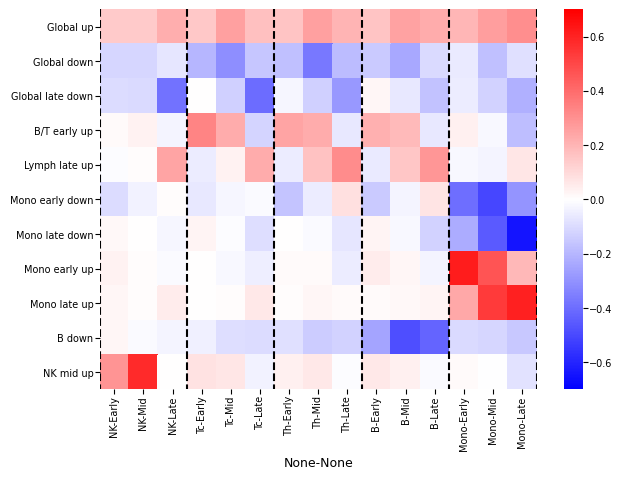

In [31]:
np.random.seed(14)
K = 11
mod = KMeans(n_clusters=K)

tocluster = logFC_clean_norm
#toplot = logFC_clean_norm
#tocluster = logFC_clean
toplot = logFC_clean

mod.fit(tocluster)
labels = pd.Series(mod.labels_+1, index=tocluster.index)
dummies = pd.get_dummies(labels)
usage = tocluster.groupby(labels).mean().sort_index()

cluster_order = [6, 3, 9,
                 8, 1,
                 4, 2, 7, 5,
                 11, 10]
cluster_label = ['Global up', 'Global down', 'Global late down', 
                 'B/T early up', 'Lymph late up',
                 'Mono early down', 'Mono late down', 'Mono early up', 'Mono late up',
                 'B down', 'NK mid up']



usage = usage.loc[cluster_order,:]
rename_map = dict(zip(cluster_order, cluster_label))

labels_lab =labels.replace(rename_map)
usage.index = [rename_map[x] for x in usage.index]

(fig,ax) = plt.subplots(1,1, figsize=(7,5), dpi=100)
thresh_new = .7
sns.heatmap(usage,xticklabels=True, vmin=-1*thresh_new, vmax=thresh_new, cmap='bwr', ax=ax)#, row_cluster=False)
for i in range(0,25,3):
    ax.vlines(x=i, ymin=0, ymax=usage.shape[0], linestyle='--')

In [32]:
labels_lab.value_counts()

Mono late down      233
Mono late up        209
Global down         156
Global late down    144
Mono early down     143
Global up           136
B/T early up        110
B down              101
Mono early up        89
Lymph late up        65
NK mid up            51
dtype: int64

## Module gene set enrichment testing

In [33]:
gsetdir = '../../../../data/Genesets/msigdb'

In [34]:
hallmark_gsetfn = os.path.join(gsetdir, 'h.all.v6.2.symbols.gmt')
c2_geneset = os.path.join(gsetdir, 'c2.all.v6.2.symbols.gmt')
combined_gset_fn = os.path.join(gsetdir,'c2andh.all.v6.2.symbols.gmt')
combine_cmd = 'cat %s %s > %s' % (hallmark_gsetfn, c2_geneset, combined_gset_fn)
print(combine_cmd)
!{combine_cmd}

cat ../../../../data/Genesets/msigdb/h.all.v6.2.symbols.gmt ../../../../data/Genesets/msigdb/c2.all.v6.2.symbols.gmt > ../../../../data/Genesets/msigdb/c2andh.all.v6.2.symbols.gmt


In [35]:
module_membership = pd.get_dummies(labels_lab).reindex(allres.index).replace(np.nan, 0).astype(bool)
module_membership.head()

,B down,B/T early up,Global down,Global late down,Global up,Lymph late up,Mono early down,Mono early up,Mono late down,Mono late up,NK mid up
AAAS,False,False,False,False,False,False,False,False,False,False,False
AACS,False,False,False,False,False,False,False,False,False,False,False
AAK1,False,False,False,False,False,False,False,False,False,False,False
AAMDC,False,False,False,False,False,False,False,False,False,False,False
AAMP,False,False,False,False,False,False,False,False,False,False,False


In [36]:
tested_genes = (~allres_Q.isnull()).sum(axis=1) > 0
tested_genes = tested_genes.index[tested_genes]

In [37]:
module_membership_tested = module_membership.loc[tested_genes, :]

In [38]:
gset_merge, gset_genes = load_geneset(combined_gset_fn,  genes=list(module_membership_tested.index), minsize=10)

gset_merge['IFN_ALPHA-GAMMA'] = gset_merge['HALLMARK_INTERFERON_ALPHA_RESPONSE'] - gset_merge['HALLMARK_INTERFERON_GAMMA_RESPONSE']
gset_merge['IFN_GAMMA-ALPHA'] = gset_merge['HALLMARK_INTERFERON_GAMMA_RESPONSE'] - gset_merge['HALLMARK_INTERFERON_ALPHA_RESPONSE']

module_membership_totest = module_membership_tested.loc[gset_genes,:]

In [76]:
print('\n'.join(gset_merge['IFN_GAMMA-ALPHA']))

SPPL2A
MTHFD2
VAMP8
CMKLR1
MARCH1
NFKB1
VAMP5
IFNAR2
OAS2
SRI
CFH
CDKN1A
CD38
CCL2
SAMHD1
ST3GAL5
MX2
HIF1A
METTL7B
PLA2G4A
XAF1
TOR1B
STAT3
SECTM1
PML
PSMA2
SSPN
SOCS1
ARL4A
NUP93
IRF4
STAT1
ZBP1
SELP
CD40
OAS3
RBCK1
CASP7
ICAM1
ITGB7
IFIT1
MYD88
GPR18
BANK1
CASP4
NLRC5
FGL2
ARID5B
PDE4B
DDX58
PNP
SERPING1
FPR1
CSF2RB
TNFAIP3
SOD2
NAMPT
IRF8
GCH1
IL15RA
APOL6
ST8SIA4
TAPBP
CD69
UPP1
TNFSF10
FAS
ZNFX1
IL2RB
PTGS2
EIF4E3
IL6
NFKBIA
HLA-DQA1
IL10RA
MVP
PSMB2
CIITA
NOD1
LCP2
BTG1
LATS2
CCL5
CD86
GZMA
RIPK1
IDO1
BPGM
ISOC1
FCGR1A
JAK2
TNFAIP6
TNFAIP2
PTPN6
CD274
PTPN1
SLAMF7
STAT4
NCOA3
LYSMD2
IRF5


In [39]:
gset_fishertest_res = fishertestbygep(gset_merge, module_membership_totest)

B down
B/T early up
Global down
Global late down
Global up
Lymph late up
Mono early down
Mono early up
Mono late down
Mono late up
NK mid up


In [40]:
gset_fishertest_res.loc[['IFN_ALPHA-GAMMA', 'IFN_GAMMA-ALPHA'], 'Global up']

,OR,P
IFN_ALPHA-GAMMA,20.8961,9.44799e-05
IFN_GAMMA-ALPHA,16.6391,2.5613e-14


In [41]:
gset_fishertest_res_P = gset_fishertest_res.xs('P', axis=1, level=1)
#for c in cluster_label:
for c in module_membership.columns:    
    (_,q,_,_) = multipletests(gset_fishertest_res_P[c], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    gset_fishertest_res[(c, 'Q')] = q

In [42]:
numsetsper = 10
with open(os.path.join(results_dir, 'DEG_geneset_enrichment.tsv'), 'w') as F:
    F.write('\tModule name\t\t\n')
    F.write('Rank\tGene set\tOR\tFDR-corrected P-value\n')
    
    #for c in cluster_label:
    for c in module_membership.columns:
        dat = gset_fishertest_res[c].sort_values(by='Q')
        F.write('\t%s\t\t\n' % c)
        for (i,setname) in enumerate(dat.index[:numsetsper]):
            F.write('%d\t%s\t%.3f\t%.3e\n' % (i+1, setname.upper(), dat.loc[setname, 'OR'], dat.loc[setname, 'Q']))

In [43]:
print('\n'.join(list(gset_merge['HALLMARK_MITOTIC_SPINDLE'].intersection(labels_lab.index[labels_lab=='Global down']))))

TIAM1
ABR
DYNC1H1
ARHGDIA
CAPZB
MYH9
EPB41
FLNA
SEPT9
SPTAN1
ACTN4
KLC1
MYO9B
SPTBN1
APC
NUMA1
TLK1


## Output other results text files

In [44]:
labels_lab_all = labels_lab.reindex(tested_genes).replace(np.nan, 'Not significant')
labels_lab_all.to_csv(os.path.join(results_dir, 'DEG_module_assignment.txt'))


In [45]:
allres_clean = allres.drop(['logP', 'logQ', 'logFC_unadjusted', 'logFC_combined'], axis=1, level=2).rename(columns={'P_H':'P'}, level=2)
gene_info = adata.raw.var[['gene_symbol', 'gene_id']]
gene_info.columns = pd.MultiIndex.from_tuples([('gene_info', 'gene_info', x) for x in gene_info.columns])
gene_info.head()
allres_clean = pd.merge(left=gene_info, right=allres_clean, left_index=True, right_index=True, how='right')
allres_clean.head()

gene_info                            NK                           \
        gene_info                         Early                      Mid   
      gene_symbol             gene_id     logFC         P    Q     logFC   
AAAS         AAAS  ENSMMUG00000022036 -0.031065  0.733987  1.0 -0.089209   
AACS         AACS  ENSMMUG00000011117  0.116593  0.568643  1.0 -0.004529   
AAK1         AAK1  ENSMMUG00000007868 -0.047030  0.543137  1.0 -0.034225   
AAMDC       AAMDC  ENSMMUG00000010119 -0.021779  0.506547  1.0 -0.018169   
AAMP         AAMP  ENSMMUG00000022812  0.004291  0.985255  1.0  0.016492   

                                          ...  cDC  Neut                      \
                          Late            ... Late Early                       
              P    Q     logFC         P  ...    Q logFC         P         Q   
AAAS   0.336743  1.0 -0.069166  0.183725  ...  1.0   NaN       NaN       NaN   
AACS   0.954206  1.0 -0.000131  0.847031  ...  1.0   NaN       NaN       NaN   
AAK1   0.855302  1.0  0.076480  0.071887  ...  NaN   NaN  0.848039  1.000000   
AAMDC  0.828635  1.0 -0.040107  0.366065  ...  1.0   NaN       NaN       NaN   
AAMP   0.845816  1.0  0.077169  0.536426  ...  1.0   NaN  0.003136  0.174804   

                                                                  
            Mid                         Late                      
          logFC         P         Q    logFC         P         Q  
AAAS        NaN       NaN       NaN      NaN       NaN       NaN  
AACS        NaN       NaN       NaN      NaN       NaN       NaN  
AAK1        NaN  0.708964  0.939651      NaN  0.651057  0.916536  
AAMDC       NaN       NaN       NaN      NaN  0.751943  0.916536  
AAMP  -0.546608  0.017106  0.362881 -0.50937  0.028648  0.802847  

[5 rows x 74 columns]

In [46]:
allres_clean.to_csv(os.path.join(results_dir, 'DEG_test_statistics.tsv'), sep='\t', index=False)


## Make big differentially expressed gene heatmap

In [47]:
logFC.loc[(list(labels_lab.index[labels_lab=='Lymph late up'])),[('Tc', 'Late'), ('Th', 'Late'), ('NK', 'Late'), ('B', 'Late')]].mean(axis=1).sort_values(ascending=False)

MAMU-B                0.786369
NCL                   0.661080
GIMAP7                0.622423
ARAP2                 0.480306
EIF5B                 0.403548
                        ...   
SETX                  0.064899
KRR1                  0.063743
TRIB2                 0.035329
ENSMMUG00000001354   -0.005182
SYTL2                -0.035448
Length: 65, dtype: float64

In [48]:
allres_Q.loc[(list(labels_lab.index[labels_lab=='B down'])), 'B'].min(axis=1).sort_values(ascending=True).head(20)

HSPA8                 2.902551e-80
ITGB2                 1.767764e-73
CD79A                 3.848774e-71
ACTB                  5.703360e-68
ENSMMUG00000018854    8.708709e-54
COTL1                 2.906747e-52
LCP1                  1.063884e-44
LMNA                  2.379471e-41
MS4A1                 1.938195e-31
VIM                   8.088706e-31
IFI30                 2.061460e-30
ACTG1                 2.556456e-27
DENND4A               4.386818e-27
PADI2                 6.298807e-27
CD1C                  9.853631e-26
PLXNB2                2.046177e-24
PSTPIP1               7.328725e-22
ANXA2                 8.963826e-21
PFN1                  1.591948e-20
DGKD                  2.843372e-20
dtype: float64

In [86]:
genes_to_label = {'Global up':['STAT1', 'MX1', 'IRF7', 'ISG15', 'MX2'],
                 'Global down':['QARS', 'NOP53', 'EIF3D', 'ATP2B1'],
                 'Global late down':['EEF2','EEF1D','EIF3E', 'PABPC1'],
                 'B/T early up':['CD69', 'TNFAIP3', 'FOS', 'FOSB'],
                  'Lymph late up':['MAMU-B', 'ARAP2', 'SSB'],
                 'Mono early down':['SMARCC1', 'CASP8AP2', 'TAOK3'],
                  'Mono late down':['MAMU-DPB', 'MAMU-DRA','CFD','IL1B', 'STAT6'],
                 'Mono early up':['CD163', 'APOBEC3A', 'TLR2', 'CCR1'],
                 'Mono late up':['PLAC8', 'S100A8', 'IL1RN', 'TNFSF10', 'MKI67'],
                 'B down':['CD79A', 'GRB2', 'SYK', 'ITGB2'],
                 'NK mid up':['CDC42', 'RHOA', 'ACTR3']}




all_label_genes = []
for k in genes_to_label.keys():
    all_label_genes +=  [genes_to_label[k], list(labels_lab_all.loc[genes_to_label[k]])]
    
pd.DataFrame(all_label_genes)

,0,1,2,3,4
0,STAT1,MX1,IRF7,ISG15,MX2
1,Global up,Global up,Global up,Global up,Global up
2,QARS,NOP53,EIF3D,ATP2B1,None
3,Global down,Global down,Global down,Global down,None
4,EEF2,EEF1D,EIF3E,PABPC1,None
5,Global late down,Global late down,Global late down,Global late down,None
6,CD69,TNFAIP3,FOS,FOSB,None
7,B/T early up,B/T early up,B/T early up,B/T early up,None
8,MAMU-B,ARAP2,SSB,None,None
9,Lymph late up,Lymph late up,Lymph late up,None,None


In [87]:
cluster_label = ['Global up', 'Global down', 'Global late down', 
                 'B/T early up', 'Lymph late up',
                 'Mono early down', 'Mono late down', 'Mono early up', 'Mono late up',
                 'B down', 'NK mid up']

In [88]:
cluster_label_rename = ['Global up', 'Global down',  'Global late\ndown', 'B/T early\nup', 'Lymph late up', 'Mono early\ndown', 
                        'Mono late\ndown', 'Mono early\nup', 'Mono late\nup', 'B down',  'NK mid\nup']
module_label_rename_map = dict(zip(cluster_label, cluster_label_rename))
module_label_rename_map

{'Global up': 'Global up',
 'Global down': 'Global down',
 'Global late down': 'Global late\ndown',
 'B/T early up': 'B/T early\nup',
 'Lymph late up': 'Lymph late up',
 'Mono early down': 'Mono early\ndown',
 'Mono late down': 'Mono late\ndown',
 'Mono early up': 'Mono early\nup',
 'Mono late up': 'Mono late\nup',
 'B down': 'B down',
 'NK mid up': 'NK mid\nup'}

In [89]:
labels_lab.loc['CD48']

'B/T early up'

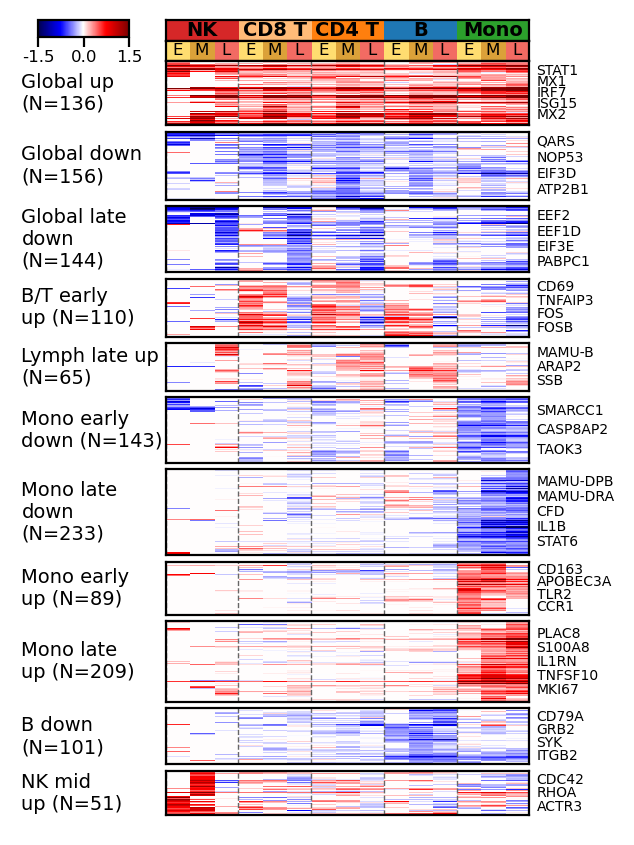

In [90]:
from matplotlib import gridspec
from fastcluster import linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import leaves_list, optimal_leaf_ordering

numgenersperlabel = labels_lab.value_counts()
toplot = logFC_clean

numgenersperlabel_subset = np.array([numgenersperlabel.loc[x] for x in cluster_label])
numgenersperlabel_frac = numgenersperlabel_subset / numgenersperlabel_subset.sum()
shared_frac = .1
numgenersperlabel_frac += shared_frac
numgenersperlabel_frac = numgenersperlabel_frac / numgenersperlabel_frac.sum()

height=4.1
width = 3.
width_ratios = [.4, 1, .2]
height_ratios = list(numgenersperlabel_frac)

label_size = .03
height_ratios[0] = height_ratios[0] + label_size*2
#hspace = [0,0]+[.1]*len(numgenersperlabel_frac)



hspace = .1
fig = plt.figure(figsize=(width, height), dpi=200)
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), fig,
                                    0.01, 0.01, 0.98, 0.98,
                                   height_ratios=height_ratios,
                                   width_ratios=width_ratios,
                                   wspace=0, hspace=hspace)



label_grid = gs[0, 1].subgridspec(3, 1, wspace=0.0, hspace=0.0, height_ratios=[label_size, label_size, height_ratios[0]-(label_size*2)])
label_axes = []
for i in range(2):
    label_axes.append(fig.add_subplot(label_grid[i], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True))

cbar_grid = gs[0, 0].subgridspec(6, 8, wspace=0.0, hspace=0.0,)
cbar_ax = fig.add_subplot(cbar_grid[0, 1:6], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True)
    
    
    
heatmap_axes = [fig.add_subplot(label_grid[2], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True)]    

for i in range(1, len(height_ratios)):
    heatmap_axes.append(fig.add_subplot(gs[i, 1], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True))


left_label_grid = gs[0, 0].subgridspec(3, 1, wspace=0.0, hspace=0.0, height_ratios=[label_size, label_size, height_ratios[0]-(label_size*2)])
left_label_axes = [fig.add_subplot(left_label_grid[2], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=False, xlim=[0,1], ylim=[0,1])]  
for i in range(1,len(height_ratios)):
    left_label_axes.append(fig.add_subplot(gs[i, 0], xscale='linear', yscale='linear',
                                      xlim=[0,1], ylim=[0,1],xlabel='', ylabel='',
                                      frameon=False, xticks=[], yticks=[]))    
    
    

right_label_grid = gs[0, 2].subgridspec(3, 1, wspace=0.0, hspace=0.0, height_ratios=[label_size, label_size, height_ratios[0]-(label_size*2)])
gene_label_axes = [fig.add_subplot(right_label_grid[2], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=False, xlim=[0,1], ylim=[0,1])]  
for i in range(1,len(height_ratios)):
    gene_label_axes.append(fig.add_subplot(gs[i, 2], xscale='linear', yscale='linear',
                                      xlim=[0,1], ylim=[0,1],xlabel='', ylabel='',
                                      frameon=False, xticks=[], yticks=[]))   
    
    
cmap = 'seismic'
vmin=-1.5; vmax=1.5
gridline_color = '0.4'
celltype_label_fontsize=7
period_label_fontsize=6

c = palettable.tableau.Tableau_20.mpl_colors
celltype_cmap = {'B':c[0],  'Tc':c[3], 'Th':c[2], 'NK':c[6], 'Mono':c[4], 'cDC':c[5], 'pDC':c[16]}
celltype_color = np.array([[celltype_cmap[x] for x in logFC.columns.get_level_values(0)],
                           [celltype_cmap[x] for x in logFC.columns.get_level_values(0)]])
label_axes[0].imshow(celltype_color, interpolation=None, cmap=cmap, aspect='auto')


#ctorder = ['CD8 T', 'NK', 'CD4 T', 'B', 'Mono', 'pDC', 'cDC']
ctorder = ['NK', 'CD8 T', 'CD4 T', 'B', 'Mono']
for (s, x) in zip(ctorder, np.arange(1, len(ctorder)*3, 3)):
    label_axes[0].text(x, .5, s, ha='center', va='center', fontsize=celltype_label_fontsize,
                       fontweight='bold')


pmap = {'Early': np.array([1.        , 0.86666667, 0.44313725]),
 'Mid': np.array([0.85882353, 0.63137255, 0.22745098]),
 'Late': np.array([0.94901961, 0.42352941, 0.39215686])}
p_color = np.array([[pmap[x] for x in logFC.columns.get_level_values(1)],
                           [pmap[x] for x in logFC.columns.get_level_values(1)]])
label_axes[1].imshow(p_color, interpolation=None, cmap=cmap, aspect='auto')
for x in range(15):
    if (x % 3) == 0:
        lab='E'
    elif (x % 3) == 1:
        lab='M'
    elif (x % 3) == 2:
        lab='L'
    label_axes[1].text(x, .5, lab, ha='center', va='center',
                     fontsize=period_label_fontsize)




gene_label_xpos = .1
for (i,cluster) in enumerate(cluster_label):
    toadd = toplot.loc[labels_lab==cluster, :]
    D = pdist(toadd, 'correlation')
    Z = linkage(D, 'ward')
    Z_ordered = optimal_leaf_ordering(Z, D)
    reorder = leaves_list(Z_ordered)
    toadd = toadd.iloc[reorder, :]
    heatmapsc = heatmap_axes[i].imshow(toadd, interpolation='none', cmap=cmap, aspect='auto',
                                rasterized=True, vmin=vmin, vmax=vmax)
    
    tolab = module_label_rename_map[cluster]
    if cluster in ['Global late down', 'Mono late down', 'Lymph late up, Mono down']:
        tolab += '\n(N=%d)' % numgenersperlabel[cluster]    
    elif '\n' in tolab:
        tolab += ' (N=%d)' % numgenersperlabel[cluster]
    else:
        tolab += '\n(N=%d)' % numgenersperlabel[cluster]
    
    
    left_label_axes[i].text(0.01, 0.5, tolab, ha='left', va='center',
                            fontsize=7)
        
    ylim = heatmap_axes[i].get_ylim()
    for x in np.arange(-.5, logFC.shape[1]-.5, 3):
        heatmap_axes[i].vlines(x=x, ymin=ylim[0], ymax=ylim[1], linestyle='--',
                  color=gridline_color, linewidth=.5)
    
    if cluster not in genes_to_label:
        continue

    num_genes_to_label = len(genes_to_label[cluster])
    if num_genes_to_label ==5:
        yposvals =  np.linspace(0.85, .15, num_genes_to_label)
    elif num_genes_to_label ==4:
        yposvals =  np.linspace(0.85, .15, num_genes_to_label)
    else:
        yposvals =  np.linspace(0.8, .2, num_genes_to_label)
    
    for j in range(num_genes_to_label):
        g = genes_to_label[cluster][j]
        ypos = yposvals[j]
        gene_label_axes[i].text(gene_label_xpos, ypos, g, ha='left', va='center',
                            fontsize=5)
        #right_label_axes[i].plot([0, 0.05], [ypos, ypos], color='k', linewidth=.5)
    
    from matplotlib import cm
    cm.ScalarMappable(cmap='bwr')

fig.colorbar(heatmapsc, cax=cbar_ax,
            ticks=np.linspace(vmin, vmax, 3),
            orientation='horizontal')
cbar_ax.set_xticklabels([str(x) for x in np.linspace(vmin, vmax, 3)], fontsize=6)


figure_file = os.path.join(results_dir, "DEGmodule.Invivo.AllCeltypesBystander.Heatmap.pdf")
fig.savefig(figure_file, dpi=300)

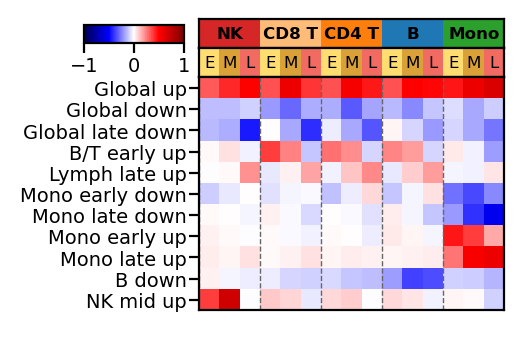

In [91]:
height=1.5
width = 2.5

left = .38
right = .99

label_size = .15
height_ratios = [label_size, label_size, height - (2*label_size)]


hspace = .1
fig = plt.figure(figsize=(width, height), dpi=200)
gs = gridspec.GridSpec(3, 1, fig, left, 0.01, right, 0.98,
                                   height_ratios=height_ratios,
                                   width_ratios=None,
                                   hspace=0)


top_label_axes = fig.add_subplot(gs[0], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True)
bottom_label_axes = fig.add_subplot(gs[1], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True)

heatmap_axes = fig.add_subplot(gs[2], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True)
    
cmap = 'seismic'
vmin=-1; vmax=1
gridline_color = '0.4'
celltype_label_fontsize=6
period_label_fontsize=6

c = palettable.tableau.Tableau_20.mpl_colors
celltype_cmap = {'B':c[0],  'Tc':c[3], 'Th':c[2], 'NK':c[6], 'Mono':c[4], 'cDC':c[5], 'pDC':c[16]}
celltype_color = np.array([[celltype_cmap[x] for x in logFC.columns.get_level_values(0)],
                           [celltype_cmap[x] for x in logFC.columns.get_level_values(0)]])
top_label_axes.imshow(celltype_color, interpolation=None, cmap=cmap, aspect='auto', rasterized=False)


#ctorder = ['CD8 T', 'NK', 'CD4 T', 'B', 'Mono', 'pDC', 'cDC']
ctorder = ['NK', 'CD8 T', 'CD4 T', 'B', 'Mono']
for (s, x) in zip(ctorder, np.arange(1, len(ctorder)*3, 3)):
    top_label_axes.text(x, .5, s, ha='center', va='center', fontsize=celltype_label_fontsize,
                       fontweight='bold')


pmap = {'Early': np.array([1.        , 0.86666667, 0.44313725]),
 'Mid': np.array([0.85882353, 0.63137255, 0.22745098]),
 'Late': np.array([0.94901961, 0.42352941, 0.39215686])}
p_color = np.array([[pmap[x] for x in logFC.columns.get_level_values(1)],
                           [pmap[x] for x in logFC.columns.get_level_values(1)]])
bottom_label_axes.imshow(p_color, interpolation=None, cmap=cmap, aspect='auto', rasterized=False)
for x in range(15):
    if (x % 3) == 0:
        lab='E'
    elif (x % 3) == 1:
        lab='M'
    elif (x % 3) == 2:
        lab='L'
    bottom_label_axes.text(x, .5, lab, ha='center', va='center',
                     fontsize=period_label_fontsize)

summary = toplot.groupby(labels_lab).mean().loc[cluster_label, :]
him = heatmap_axes.imshow(summary, interpolation='none', cmap=cmap, aspect='auto',
                                rasterized=True, vmin=vmin, vmax=vmax)
heatmap_axes.set_yticks(np.arange(len(cluster_label)))
heatmap_axes.set_yticklabels(cluster_label)
heatmap_axes.grid(False)


ylim = heatmap_axes.get_ylim()
for x in np.arange(-.5, summary.shape[1]-.5, 3):
    heatmap_axes.vlines(x=x, ymin=ylim[0], ymax=ylim[1], linestyle='--',
                  color=gridline_color, linewidth=.5)
    
    
cbarax = fig.add_axes([.15, .9, .2, .06, ],
                     xticks=[], yticks=[],
                     xlim=[0,1], ylim=[0,1])
plt.colorbar(him, cax=cbarax, ticks=[-1,0,1], orientation='horizontal', )

    
figure_file = os.path.join(results_dir, "DEGmodule.Invivo.AllCeltypesBystander.SummaryHeatmap.pdf")
fig.savefig(figure_file, dpi=300,rasterized=False)

## Monocyte example volcano plot

In [56]:
mono = allres.loc[:, ('Mono', 'Late')]
mono = pd.merge(left=mono, right= pd.DataFrame(labels_lab_all, columns=['label']), left_index=True, right_index=True, how='left')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [57]:
mono['label'].unique()

array(['Not significant', 'Lymph late up', 'Global late down', 'B down',
       'Global down', 'Mono late down', 'Mono late up', 'Mono early up',
       'NK mid up', 'Global up', 'Mono early down', 'B/T early up', nan],
      dtype=object)

ENSMMUG00000008227 - protein family HLA CLASS II HISTOCOMPATIBILITY ANTIGEN BETA CHAIN PRECURSOR MHC CLASS II ANTIGEN https://jul2019.archive.ensembl.org/Macaca_mulatta/Gene/Family?db=core;g=ENSMMUG00000008227;r=4:33349415-33356191;t=ENSMMUT00000040920


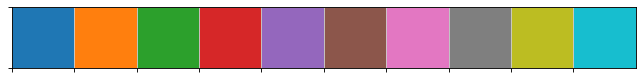

In [58]:
colors = palettable.tableau.Tableau_10.hex_colors
sns.palplot(colors)

cat2color = {'Other':colors[7],  'Mono up':colors[2], 'Mono down':colors[5], 'Global up':colors[3], 'Global down':colors[0], 'MHC-II':colors[6]}

mono['succinct_label'] = 'Other'
rename_map = {'Mono early up':'Mono up', 'Mono late up':'Mono up', 'Mono late down':'Mono down', 'Mono early down':'Mono down',
              
              'Global up':'Global up', 'Global down':'Global down',
             'Lymph late up, Mono down':'Mono down', 'Global late down':'Global down'}
ind = mono['label'].isin(['Global up', 'Global down'] + list(rename_map.keys()))
mono.loc[ind, 'succinct_label'] = mono.loc[ind, 'label'].replace(rename_map)
mhc2_module = [x for x in mono.index if ('MAMU-D' in x) or ('HLA-D' in x)] + ['ENSMMUG00000008227', 'CD74', 'ZFP36', 'LGMN', 'CPVL']
mono.loc[mhc2_module, 'succinct_label'] = 'MHC-II'
mono.loc[mhc2_module, 'color'] = colors[4]

mono.loc[:, 'color'] = mono['succinct_label'].replace(cat2color)

IFI27 -0.1 0.0 right center
ISG15 -0.1 0.0 right center
MX1 -0.1 0.0 right center
PLAC8 -0.1 0.0 right center
OAS2 -0.1 0.0 right center
IFIT1 0 2.0 center bottom
IFIT3 -0.1 3 right center
S100A9 0 2.0 center bottom
GBP2 0.1 0.0 left center
IFI6 -0.1 0.0 right center
IFIT2 0.1 -3 left top
S100A8 0.1 -3 left top
DDX58 -0.1 3 right center
IFI44 0.1 0.0 left center
MX2 0.1 0.0 left center
PSAP 0 2.0 center bottom
CFD 0 2.0 center bottom
CTSS 0 2.0 center bottom
PABPC1 0.1 3 left center
MAMU-DPB -0.1 3 right center
MAMU-DRA -0.1 0.0 right center
MAMU-DPA -0.1 -3 right top
RACK1 0.1 0.0 left center
CD52 -0.1 -2 right top
MAMU-DQA1 0.1 3 left center
CPVL -0.1 -3 right top


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


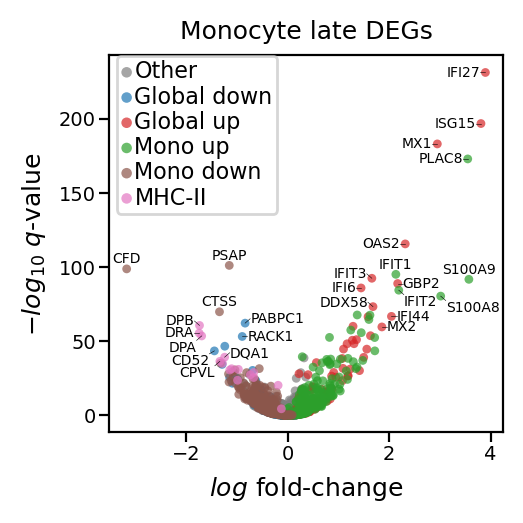

In [59]:
fig = plt.figure(constrained_layout=True, figsize=(2.5,2.5), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.1,
                       bottom=.1, right=.95, top=.9)
ax = fig.add_subplot(gs[0],
                     ylabel='', xlabel='',
                     title='')

order = ['Other', 'Global down', 'Global up', 'Mono up', 'Mono down', 'MHC-II']
xvar = 'logFC_combined'
yvar = 'logQ'
for k in order:
    g = mono.loc[mono['succinct_label']==k, :]
    #ax.scatter(g[xvar], g[yvar], label=k, s=g['size'],
    #           edgecolor='None', alpha=.7, color=cat2color[k])
    ax.scatter(g[xvar], g[yvar], label=k, s=10,
               edgecolor='None', alpha=.7, color=cat2color[k])
    
ax.grid(False)


leg = ax.legend(loc=(0.02, 0.58), fontsize=8,
                markerscale=1.2,
                title_fontsize=8,handletextpad=0.1,
                labelspacing=.1, borderpad=.2)

ax.set_xlabel('$log$ fold-change')
ax.set_ylabel('$-log_{10}$ $q$-value')
ax.set_title('Monocyte late DEGs')

default_x_shift = 0
default_y_shift = 1.5
default_ha='center'
default_va='bottom'
labfontsize=5

ordered = mono.loc[mono[xvar]>0,:].sort_values(by=yvar, ascending=False)
up_to_label = list(ordered.index[ordered[yvar]>80])
ordered = mono.loc[mono[xvar]<0,:].sort_values(by=yvar, ascending=False)
down_to_label = list(ordered.index[ordered[yvar]>52])
rename = {'ENSMMUG00000045411':'CD300H', 'FCGR3':'FCGR3 (CD16)', 'ENSMMUG00000049198':'KLF13',
         'MAMU-DPB':'DPB', 'MAMU-DRA':'DRA', 'MAMU-DPA':'DPA', 'MAMU-DQA1':'DQA1'}

down_to_label += ['CD52', 'MAMU-DQA1', 'CPVL']
up_to_label += ['DDX58', 'IFI44', 'MX2']
genes_to_label = up_to_label + down_to_label

params = {
'above':{'x_shift':0, 'y_shift':2., 'ha':'center', 'va':'bottom'},
'right':{'x_shift':.1, 'y_shift':0., 'ha':'left', 'va':'center'},
'left':{'x_shift':-.1, 'y_shift':0., 'ha':'right', 'va':'center'},
'below':{'x_shift':0, 'y_shift':-4, 'ha':'center', 'va':'top'},
'upper-right':{'x_shift':.1, 'y_shift':3, 'ha':'left', 'va':'center'},
'lower-right':{'x_shift':.1, 'y_shift':-3, 'ha':'left', 'va':'top'},
'upper-left':{'x_shift':-.1, 'y_shift':3, 'ha':'right', 'va':'center'},
'lower-left':{'x_shift':-.1, 'y_shift':-3, 'ha':'right', 'va':'top'},
}

category = {
'above':['IFIT1', 'S100A9', 'PSAP', 'CFD', 'CTSS'],
'right':['GBP2', 'RACK1', 'IFI44', 'MX2'],
'left':['IFI27', 'ISG15', 'MX1', 'PLAC8', 'OAS2', 'IFI6',
       'MAMU-DRA'],
'below':[],
'upper-right':['PABPC1', 'MAMU-DQA1'],
'lower-right':['IFIT2', 'S100A8'],
'upper-left':[ 'IFIT3', 'MAMU-DPB', 'DDX58'],
'lower-left':['MAMU-DPA', 'CPVL'],

}

other_param = {'CD52':[-.1, -2, 'right', 'top']}


gene2cat = {g:c for c in category.keys() for g in category[c]}
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xwidth = xlim[1] - xlim[0]
ywidth = ylim[1] - ylim[0]

for g in genes_to_label:

    if g in other_param:
      (x_shift,y_shift,ha,va) = other_param[g]

    elif g in gene2cat:
      x_shift = params[gene2cat[g]]['x_shift']
      y_shift = params[gene2cat[g]]['y_shift']
      ha = params[gene2cat[g]]['ha']
      va = params[gene2cat[g]]['va']
    else:
      x_shift = default_x_shift
      y_shift = default_y_shift
      ha = default_ha
      va = default_va
      #continue

    
    if g in rename:
      tolab = rename[g]
    else:
      tolab = g
    
    ax.text(mono.loc[g, xvar]+x_shift, mono.loc[g, yvar]+y_shift,
          tolab, fontsize=labfontsize, va=va, ha=ha)

    yline = np.array([mono.loc[g, yvar], mono.loc[g, yvar]+y_shift])
    xline = np.array([mono.loc[g, xvar], mono.loc[g, xvar]+x_shift])
    dist = np.sqrt(((xline[1]-xline[0]) / xwidth)**2 + ((yline[1]-yline[0])/ ywidth)**2)
    
    if (dist>.01):
        ax.plot(xline, yline, color='k', linewidth=.2)
    
    print(g, x_shift, y_shift, ha, va)
    
    
qthresh = .01
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)


figure_file = os.path.join(results_dir, "DifferentialExpression.Invivo.MonocyteBystanderLate.Volcano.20200219.pdf")
fig.savefig(figure_file, dpi=200)

## Assign IFN score

In [60]:
literature_interferon = gset_merge['HECKER_IFNB1_TARGETS'].union(gset_merge['BROWNE_INTERFERON_RESPONSIVE_GENES']).union(gset_merge['MOSERLE_IFNA_RESPONSE']).union(gset_merge['HALLMARK_INTERFERON_ALPHA_RESPONSE']).union(gset_merge['HALLMARK_INTERFERON_GAMMA_RESPONSE'])
broad_upregulated = labels_lab.index[labels_lab=='Global up']
interferon_set = list(literature_interferon.intersection(broad_upregulated))
len(interferon_set)

58

In [94]:
print('\n'.join(sorted(interferon_set)))

ADAR
APOBEC3G
APOL6
B2M
BANK1
CASP1
DDX58
DDX60
DDX60L
DHX58
EIF2AK2
EPSTI1
FAS
GBP2
HERC5
HERC6
HIF1A
IFI16
IFI27
IFI35
IFI44
IFI6
IFIH1
IFIT3
IRF7
IRF9
ISG15
ISG20
LGALS3BP
MX1
MX2
NFKBIA
NMI
OAS2
OAS3
PARP14
PARP9
PML
PSMB8
PSMB9
PSME2
PTPN1
RARRES3
RSAD2
SAMD9
SAMD9L
SAMHD1
SP100
STAT1
STAT3
TRIM22
TRIM25
TRIM5
UBE2L6
VAMP5
WARS
XAF1
ZNFX1
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [101]:
#adatrawfn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adat_fn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))

#adata_for_ifn_score = read_adata(adat_fn, gcs=gcs)
adata_for_ifn_score = sc.AnnData(adata_for_ifn_score.raw.X, obs=adata_for_ifn_score.obs, var=adata_for_ifn_score.raw.var, uns=adata_for_ifn_score.uns)
adata_for_ifn_score.raw = adata_for_ifn_score.copy()
adata_for_ifn_score = adata_for_ifn_score[:, ~adata_for_ifn_score.var['Combined_Blacklist']]


sc.pp.filter_genes(adata_for_ifn_score, min_cells=10)
sc.pp.normalize_per_cell(adata_for_ifn_score, counts_per_cell_after=10000)
sc.pp.log1p(adata_for_ifn_score)

filtered out 241 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [102]:
sc.tl.score_genes(adata_for_ifn_score, gene_list=interferon_set, ctrl_size=len(interferon_set), score_name='ifn_score')

computing score 'ifn_score'
    finished: added
    'ifn_score', score of gene set (adata.obs) (0:00:21)


In [103]:
ISG_fn = os.path.join(adir, '{project}.ISGs.txt'.format(project=project_name))
open(ISG_fn, 'w').write('\n'.join(interferon_set))

345

In [104]:
adata_for_ifn_score.obs['Subclustering_clean'] = adata_for_ifn_score.obs['Subclustering_reduced'].replace({'Tc':'CD8 T', 'Th':'CD4 T'})

In [105]:
X = adata_for_ifn_score.obs.copy()

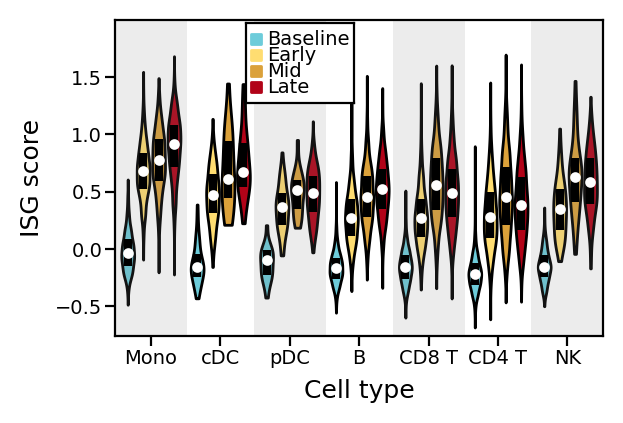

In [106]:
colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
dpimap = dict(zip(list(range(9)), colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap[0] = palettable.tableau.TableauMedium_10.mpl_colors[-1]
periodmap = {'Baseline':dpimap[0], 'Early':dpimap[3], 'Mid':dpimap[5], 'Late':dpimap[8]}

between_period_space = .1
between_celltype_space = .3
widths=.5

celltypes = ['Mono','cDC', 'pDC', 'B', 'CD8 T', 'CD4 T', 'NK']
periods = ['Baseline', 'Early', 'Mid', 'Late']

subdata = []
xpos = []
xnow = 0
X_celltype = []
X_period = []
for ct in celltypes:
    for p in periods:
        ind = (X['Subclustering_clean']==ct) & (X['Period'] == p)
        if ind.sum()==0:
          print(ct, p)
          sys.exit(-1)
        subdata.append(list(X.loc[ind, 'ifn_score'].values))
        X_celltype.append(ct)
        X_period.append(p)
        xpos.append(xnow)
        xnow+=(widths + between_period_space)
    
    xnow+=between_celltype_space


fig = plt.figure(constrained_layout=True, figsize=(3,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.1, right=.95, top=.9)
ax = fig.add_subplot(gs[0],
                     ylabel='ISG Score', xlabel='Cell type',
                     title='')

parts = ax.violinplot(
        subdata, positions=xpos, showmeans=False, showmedians=False,
        showextrema=False, widths=widths)


for (i,pc) in enumerate(parts['bodies']):
    pc.set_facecolor(periodmap[X_period[i]])
    pc.set_edgecolor('black')
    pc.set_alpha(1)


medians = [np.median(x) for x in subdata]
quartile1 = [np.percentile(x, 25) for x in subdata]
quartile3 = [np.percentile(x, 75) for x in subdata]
ax.scatter(xpos, medians, marker='o', color='white', s=8, zorder=3)
  
    
for i in range(len(subdata)):
    ax.vlines(xpos[i], quartile1[i], quartile3[i], color='k', linestyle='-', lw=3)
    
    
ax.grid(False)


centers = pd.Series(xpos).groupby(pd.Series(X_celltype)).mean().sort_values()
ax.set_xticks(list(centers.values))
ax.set_xticklabels(centers.index)

ax.set_ylabel('ISG score')
ylim = ax.get_ylim()

lefts = pd.Series(xpos).groupby(pd.Series(X_celltype)).min().sort_values()-widths
rights = pd.Series(xpos).groupby(pd.Series(X_celltype)).max().sort_values()+widths
for i in range(len(lefts)):
    if (i % 2)==0:
        ax.axvspan(lefts.iloc[i], rights.iloc[i], ymin=ylim[0], ymax=ylim[1], facecolor='gray', alpha=0.15)
   
ax.set_xlim([lefts[0], rights[-1]])
ax.set_yticks([-.5, 0, .5, 1, 1.5])
ax.set_ylim([-0.7641993224620819, 2.0])

legax = fig.add_axes([.39, .77, .18, .2, ],
                     xticks=[], yticks=[],
                     xlim=[0,1], ylim=[0,1])

ypos = np.linspace(0,1, len(periods)+2)[1:-1][::-1]
xpos = .1
text_offset = .1
for i,p in enumerate(periods):
  legax.scatter(xpos, ypos[i], color=periodmap[p], s=14, marker='s')
  legax.text(xpos+text_offset, ypos[i], p, fontsize=7, va='center')
    
figure_file = os.path.join(results_dir, "IFNscore.Invivo.Allcelltypes.Violin.pdf")
fig.savefig(figure_file, dpi=200)

In [107]:
from scipy.stats import ranksums
res = dict()
for (k,g) in adata_for_ifn_score.obs.groupby('Subclustering_clean'):
    basevals = g.loc[g['Period']=='Baseline', 'ifn_score']
    for period in ['Early', 'Mid', 'Late']:
        testvals = g.loc[g['Period']==period, 'ifn_score']
        (H,P) = ranksums(basevals, testvals)
        res[(k,period)] = P
        
pd.Series(res).max()

8.92038489516121e-06

## MHC plot

In [108]:
expression_all = pd.DataFrame(adata_for_ifn_score.X.todense(), index=adata_for_ifn_score.obs.index, columns=adata_for_ifn_score.var.index)
obs = adata_for_ifn_score.obs
expression_all_mono = expression_all.loc[obs.index[obs['Subclustering_reduced']=='Mono'], :]

In [109]:
mhc_genes = [x for x in expression_all_mono.columns if ('MAMU-D' in x) or ('HLA-D' in x)]
mhc_genes

['MAMU-DMA',
 'MAMU-DOB',
 'MAMU-DOA',
 'MAMU-DPB',
 'MAMU-DPA',
 'HLA-DQA1',
 'HLA-DQB1',
 'MAMU-DMB',
 'MAMU-DRB1',
 'MAMU-DRA',
 'MAMU-DQA1']

In [110]:
R_mhc2 = expression_all_mono.corrwith(expression_all_mono.loc[:, mhc_genes].mean(axis=1), method='spearman')

In [111]:
R_mhc2.sort_values(ascending=False).head(50)

index
MAMU-DPA              0.786806
MAMU-DRA              0.780146
MAMU-DPB              0.723285
MAMU-DMA              0.640383
HLA-DQA1              0.613984
MAMU-DQA1             0.597383
MAMU-DRB1             0.579441
MAMU-DMB              0.564467
PSAP                  0.522386
ENSMMUG00000008227    0.453372
CFD                   0.434843
ZFP36                 0.431920
CD74                  0.420135
CDKN1A                0.413181
LGMN                  0.413162
CPVL                  0.398544
IFI30                 0.382413
FTH1                  0.378110
EEF1A1                0.375161
CTSS                  0.370357
HLA-DQB1              0.352845
RASGEF1B              0.352061
CST3                  0.339041
SLC25A6               0.338094
TYROBP                0.330297
B2M                   0.328602
KLF10                 0.323879
ZFP36L1               0.321255
PABPC1                0.320724
ENSMMUG00000047461    0.318634
KLF4                  0.318501
ENSMMUG00000045411    0.317780
LM

In [112]:
R_mhc2.loc['B2M']

0.32860203397549914

In [113]:
R_mhc2.loc['CIITA']

0.07448263891096091

In [114]:
from scipy.stats import spearmanr

In [115]:
average = expression_all_mono.loc[:, mhc_genes].mean(axis=1)

In [122]:
print('CD74', spearmanr(average, expression_all_mono['CD74']))
print('LGMN', spearmanr(average, expression_all_mono['LGMN']))
print('B2M', spearmanr(average, expression_all_mono['B2M']))
print('ZFP36', spearmanr(average, expression_all_mono['ZFP36']))

CD74 SpearmanrResult(correlation=0.4201352077100511, pvalue=1.7802998193281934e-296)
LGMN SpearmanrResult(correlation=0.4131616389704322, pvalue=8.066788065840619e-286)
B2M SpearmanrResult(correlation=0.32860203397549914, pvalue=2.6326678937702207e-175)
ZFP36 SpearmanrResult(correlation=0.4319204075152409, pvalue=0.0)


In [573]:
[x for x in expression_all_mono.columns if 'CIIT' in x]

['CIITA']

In [574]:
genes_to_plot = (['MHC-II',['MAMU-DPA', 'MAMU-DPB','MAMU-DRA', 'MAMU-DRB1', 'MAMU-DQA1',  'HLA-DQA1','HLA-DQB1']],
['MHC 1',['MAMU-A', 'MAMU-A3', 'MAMU-B', 'MAMU-B18']],
['Other',['MAMU-DMA', 'MAMU-DMB', 'CD74', 'LGMN', 'CPVL', 'ZFP36', 'CIITA']])

allgenes = []
for genegroup in genes_to_plot:
    allgenes += genegroup[1]

mhc_expression = expression_all.loc[:, allgenes]
mhc_expression.loc[:,'Period'] = obs['Period']
mhc_expression.loc[:,'Subclustering_clean'] = obs['Subclustering_reduced'] #.replace({'Tc':'T', 'Th':'T'})
mhc_expression.loc[:,'DPIc'] = obs['DPIc']
mhc_expression.loc[:,'Ebola_Positive'] = obs['Ebola_Positive']
mhc_expression.loc[:,'percent_EBOV'] = obs['percent_EBOV']
mhc_expression.loc[:,'ifn_score'] = obs['ifn_score']
mhc_expression.loc[:,'Log10_EBOV_TPM'] = np.log10(obs['percent_EBOV']*100000+1)
mhc_expression.loc[:,'MX1'] = adata_for_ifn_score.obs_vector('MX1')

In [575]:
allres_P

NK                            Tc                            Th  \
            Early       Mid      Late     Early       Mid      Late     Early   
AAAS     0.733987  0.336743  0.183725  0.623448  0.863229  0.560386  0.204801   
AACS     0.568643  0.954206  0.847031  0.821905  0.825774  0.168727  0.012804   
AAK1     0.543137  0.855302  0.071887  0.489859  0.023816  0.021093  0.000876   
AAMDC    0.506547  0.828635  0.366065  0.993673  0.139149  0.906231  0.960256   
AAMP     0.985255  0.845816  0.536426  0.623280  0.605949  0.913992  0.261689   
...           ...       ...       ...       ...       ...       ...       ...   
TTC16         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
TTLL7         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ZNF773        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ZPLD1         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ZSCAN12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                                    B  ...      Mono       pDC            \
              Mid      Late     Early  ...      Late     Early       Mid   
AAAS     0.236104  0.000197  0.354777  ...  0.001712  0.337769  0.922979   
AACS     0.234790  0.135422  0.420864  ...  0.087242  0.824347  0.911983   
AAK1     0.000549  0.364227       NaN  ...  0.553875  0.619983  0.162400   
AAMDC    0.922546  0.726986  0.274065  ...  0.170028  0.447836  0.685321   
AAMP     0.046581  0.777098  0.051320  ...  0.517102  0.522501  0.220405   
...           ...       ...       ...  ...       ...       ...       ...   
TTC16         NaN       NaN       NaN  ...       NaN       NaN       NaN   
TTLL7         NaN       NaN       NaN  ...       NaN       NaN       NaN   
ZNF773        NaN       NaN       NaN  ...       NaN       NaN       NaN   
ZPLD1         NaN       NaN       NaN  ...       NaN       NaN       NaN   
ZSCAN12       NaN       NaN       NaN  ...       NaN       NaN       NaN   

                        cDC                          Neut                      
             Late     Early       Mid      Late     Early       Mid      Late  
AAAS     0.997299  0.527974  1.000000  0.804712       NaN       NaN       NaN  
AACS     0.832103  0.865918  0.878801  0.841318       NaN       NaN       NaN  
AAK1     0.205684  0.642051  0.459210       NaN  0.848039  0.708964  0.651057  
AAMDC    0.586742  0.242176  1.000000  0.458490       NaN       NaN  0.751943  
AAMP     0.548088  0.281926  0.525500  0.872437  0.003136  0.017106  0.028648  
...           ...       ...       ...       ...       ...       ...       ...  
TTC16         NaN       NaN       NaN  0.088770       NaN       NaN       NaN  
TTLL7         NaN       NaN       NaN  0.597311       NaN       NaN       NaN  
ZNF773        NaN       NaN       NaN  0.699086       NaN       NaN       NaN  
ZPLD1         NaN       NaN       NaN  0.673196       NaN       NaN       NaN  
ZSCAN12       NaN       NaN       NaN  0.643086       NaN       NaN       NaN  

[12309 rows x 24 columns]

In [576]:
allres_Q = allres.xs('Q', axis=1, level=2)
gene_Q_value = allres_Q.loc[mhc_expression.columns[:18],:]
gene_Q_value = gene_Q_value.rename(index=mapper)
#T_merge = gene_Q_value[['Tc', 'Th']].groupby(axis=1, level=1).min()
#T_merge.columns = pd.MultiIndex.from_tuples([('T', x) for x in T_merge.columns])
#gene_Q_value = gene_Q_value.drop(['Tc','Th'], axis=1, level=0)
#gene_Q_value = pd.concat([gene_Q_value, T_merge], axis=1)
gene_Q_value.head()

Th                            Tc                          \
          Early       Mid      Late     Early       Mid          Late   
index                                                                   
DPA    0.097947  0.168118  0.000373  0.850344  0.227783  6.930236e-10   
DPB    0.384227  1.000000  0.436496  0.936596  0.199087  1.065242e-06   
DRA    0.990122  0.770061  0.091047  0.185089  0.917397  9.775452e-09   
DRB1        NaN       NaN       NaN  1.000000  0.227964  7.791231e-02   
DQA1        NaN       NaN  0.995961  1.000000  1.000000  5.979333e-04   

                  B                            NK  ...          Mono  Neut  \
              Early       Mid          Late Early  ...          Late Early   
index                                              ...                       
DPA    5.857388e-05  1.000000  3.657879e-23   1.0  ...  3.505312e-54   1.0   
DPB    5.179056e-03  0.000018  4.936857e-32   1.0  ...  2.875559e-61   NaN   
DRA    1.169108e-09  0.985664  1.738339e-52   1.0  ...  4.260192e-56   1.0   
DRB1   1.249610e-03  0.013530  9.899267e-07   1.0  ...  4.748419e-28   NaN   
DQA1   1.917572e-02  1.000000  5.595900e-30   1.0  ...  7.291225e-40   1.0   

                            pDC                      cDC                      
            Mid      Late Early       Mid Late     Early       Mid      Late  
index                                                                         
DPA    0.939651  0.916536   1.0  0.610705  1.0  0.966276  1.000000  0.963651  
DPB    0.939651  0.916536   1.0  0.847534  1.0  0.052982  0.802056  0.725593  
DRA    0.939651  0.916536   1.0  0.946258  1.0  0.180146  1.000000  1.000000  
DRB1        NaN       NaN   1.0  0.946258  1.0  1.000000  1.000000  0.881575  
DQA1        NaN       NaN   1.0  0.940340  1.0  0.159120  0.503091  0.683787  

[5 rows x 24 columns]

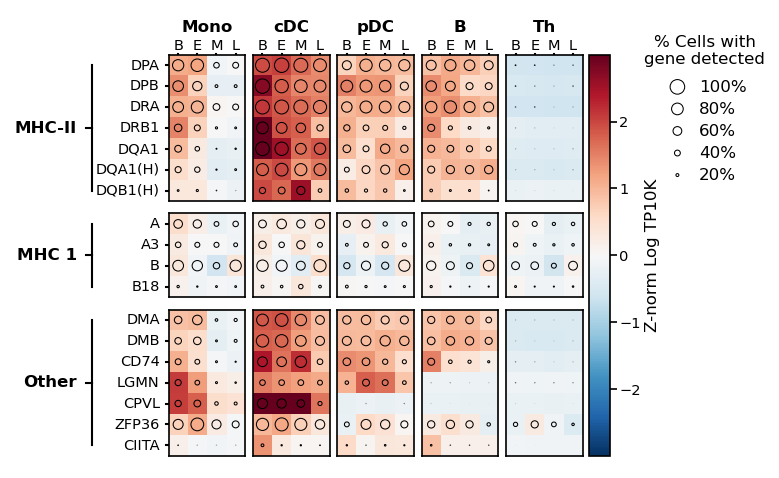

In [577]:
#expression_raw = pd.DataFrame(adata_log1p_apcset[:, allgenes].X.todense(), index=adata_log1p_apcset.obs.index, columns=allgenes)
expression = mhc_expression.copy()
q_thresh=.05

#expression.columns = [x.split('-')[1] for x in expression.columns]
newcols = []
for c in expression.columns:
    if 'MAMU' in c:
        newcols.append(c.split('-')[1])
    elif 'HLA' in c:
        newcols.append(c.split('-')[1]+'(H)')
    else:
        newcols.append(c)
mapper = dict(zip(expression.columns, newcols))
expression.columns = newcols
#genes_to_plot2 = [[x[0], [y.split('-')[1] for y in x[1]]] for x in genes_to_plot]
genes_to_plot2 = [[x[0], [mapper[y] for y in x[1]]] for x in genes_to_plot]

percent_positive = expression.groupby(['Subclustering_clean', 'Period']).agg(lambda x: (x>0).mean())

expression_norm = expression.copy()
expression_norm.iloc[:,:-8] = expression_norm.iloc[:,:-8] - expression_norm.iloc[:,:-8].mean(axis=0)
expression_norm.iloc[:,:-8] = expression_norm.iloc[:,:-8] / expression_norm.iloc[:,:-8].std(axis=0)
average_expression = expression_norm.groupby(['Subclustering_clean', 'Period']).mean()
#celltypes = ['Mono', 'cDC', 'pDC', 'B', 'T']
celltypes = ['Mono', 'cDC', 'pDC', 'B', 'Th']
order = []
for c in celltypes:
    for p in ['Baseline', 'Early', 'Mid', 'Late']:
        order.append((c,p))

average_expression = average_expression.loc[order,:]

num_gene_groups = len(genes_to_plot2)
num_genes_per_group = [len(x[1]) for x in genes_to_plot2]

num_celltype_groups = len(celltypes)
num_periods_per_celltype = [4]*len(celltypes)

width=5
height=3
heatmap_width=4
genelabel_width=1.4
legend_width=1.7
heatmap_height = 3
celllabel_height = .3
genegroup_hspace = .1
cellgroup_wspace = .1
color_map = 'Reds'
genelabelfontsize = 7
genegroupfontsize = 8
periodlabelfontsize = 7
sizelegendfontsize = 8
siggene_linewidth = 1.3
siggene_linecolor = 'k'
dotscaler = 7 #9.4


fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=2,
        ncols=3,
        wspace=0,
        hspace=0,
        width_ratios=[
            genelabel_width,
            heatmap_width,
            legend_width,
        ],
        height_ratios=[
            celllabel_height,
            heatmap_height
        ], left=.01, right=.99, bottom=.01, top=.99)


legend_grid = full_gs[1, 2].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])





genelabel_grid = full_gs[1, 0].subgridspec(num_gene_groups, 1, wspace=0.0, hspace=genegroup_hspace,
                                           height_ratios=num_genes_per_group)
genelabel_axes = [fig.add_subplot(genelabel_grid[i], xticks=[], yticks=[],
                                  ylim=[-.5, num_genes_per_group[i]-.5], xlim=[0,1], frameon=False) for i in range(num_gene_groups)]


celllabel_grid = full_gs[0, 1].subgridspec(1, num_celltype_groups, wspace=cellgroup_wspace, hspace=0,
                                           width_ratios=num_periods_per_celltype)
celllabel_axes = [fig.add_subplot(celllabel_grid[i], xticks=[], yticks=[],
                                  xlim=[-.5,num_periods_per_celltype[i]-.5],
                                 ylim=[0,1], frameon=False) for i in range(num_celltype_groups)]

heatmap_grid = full_gs[1, 1].subgridspec(num_gene_groups, num_celltype_groups, wspace=cellgroup_wspace, hspace=genegroup_hspace,
                                           width_ratios=num_periods_per_celltype, height_ratios=num_genes_per_group)
heatmap_axes = []
for i in range(num_gene_groups):
    rows = []
    for j in range(num_celltype_groups):
        rows.append(fig.add_subplot(heatmap_grid[i,j], xticks=[], yticks=[], ylim=[-.5, num_genes_per_group[i]-.5],
                                   xlim=[-.5,num_periods_per_celltype[j]-.5]))
    heatmap_axes.append(rows)


period_to_x = {'Baseline':0, 'Early':1, 'Late':3, 'Mid':2}

alldotsize = percent_positive.copy()
alldotsize = alldotsize - alldotsize.min().min()
alldotsize = alldotsize / alldotsize.max().max()
alldotsize = (alldotsize * dotscaler) ** 2

allcolors = average_expression.copy()
vmin=-3
vmax=3
cmap = "RdBu_r"

from matplotlib.lines import Line2D

center_bracket_start_pos=.43
center_bracket_end_pos=.47
for (i, genegroup) in enumerate(genes_to_plot2):
    group_label = genegroup[0]
    genes = genegroup[1]
    
    center_y = -.5 + (num_genes_per_group[i]/2)
    genelabel_axes[i].text(x=0.37, y=center_y, s=group_label, horizontalalignment='right',
                           verticalalignment='center', fontsize=genegroupfontsize, fontweight='bold')
    
    genelabel_axes[i].plot([center_bracket_start_pos, center_bracket_end_pos], [center_y, center_y], linewidth=1, color='k')
    genelabel_axes[i].plot([center_bracket_end_pos, center_bracket_end_pos], [0, center_y], linewidth=1, color='k')
    genelabel_axes[i].plot([center_bracket_end_pos, center_bracket_end_pos], [num_genes_per_group[i]-1, center_y], linewidth=1, color='k')

    
    for (k, g) in enumerate(genes):
        yval = num_genes_per_group[i] -1 - k
        genelabel_axes[i].text(x=.94, y=yval, s=g, horizontalalignment='right', verticalalignment='center', fontsize=genelabelfontsize)
        genelabel_axes[i].plot([.98, 1], [yval, yval], color='k', linewidth=1)
        

    for (j, celltype) in enumerate(celltypes):
        cim= heatmap_axes[i][j].imshow(allcolors.loc[celltype, genes[::-1]].T, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        for (k, g) in enumerate(genes):
            dotsize = alldotsize.loc[celltype,g]
            yvals = [num_genes_per_group[i] -1 - k]*len(dotsize)
            xvals = [period_to_x[period] for period in dotsize.index]
            heatmap_axes[i][j].scatter(xvals, yvals, color="none", marker='o',
                                      s=dotsize.values, norm=None,
                                       edgecolor='k', linewidth=.5)
            
            '''
            for (l, period) in enumerate(['Early', 'Mid', 'Late']):
                if gene_Q_value.loc[g, (celltype, period)] < q_thresh:
                    heatmap_axes[i][j].hlines(y=(len(genes) - k -1.5), xmin=(l+.5), xmax=(l+1.5), linestyles='solid', linewidth=siggene_linewidth, color=siggene_linecolor)
                    heatmap_axes[i][j].hlines(y=(len(genes) - k -.5), xmin=(l+.5), xmax=(l+1.5), linestyles='solid', linewidth=siggene_linewidth, color=siggene_linecolor)
                    heatmap_axes[i][j].vlines(x=(l+.5), ymin=(len(genes) - k -1.5),  ymax=(len(genes) - k -.5),  linestyles='solid', linewidth=siggene_linewidth, color=siggene_linecolor)
                    heatmap_axes[i][j].vlines(x=(l+1.5), ymin=(len(genes) - k -1.5),  ymax=(len(genes) - k -.5),  linestyles='solid', linewidth=siggene_linewidth, color=siggene_linecolor)            
            '''
        #if (celltype == 'Mono') and (i==1):
        #    sys.exit(-1)

for (j, celltype) in enumerate(celltypes):
    for k in period_to_x.keys():
        celllabel_axes[j].text(period_to_x[k], .04, k[0], horizontalalignment='center', verticalalignment='bottom', fontsize=periodlabelfontsize)
        celllabel_axes[j].plot([period_to_x[k], period_to_x[k]], [0, .02], color='k', linewidth=1)
        
    center_x = -.5 + (num_periods_per_celltype[j]/2)
    celllabel_axes[j].text(x=center_x, y=.7, s=celltype.replace(' ', '\n'), ha='center',
                           va='center', fontsize=genegroupfontsize, fontweight='bold')


plt.colorbar(cim, cax=cbar_ax, ticks=[-2, -1, 0, 1, 2])
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])

vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * dotscaler) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .25

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.7, .92, 5)

size_legend_ax.scatter(leg_x, leg_y, s=leg_dot_size, edgecolor='k', color='none', linewidth=.5)
size_legend_ax.text(-0.05, .5, 'Z-norm Log TP10K', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)
for i in range(5):
    size_legend_ax.text(leg_x[i]+text_offset, leg_y[i], ('%d' % (100*vals[i])) + '%', fontsize=sizelegendfontsize, va='center')
size_legend_ax.text(.5, 1.05, '% Cells with\ngene detected', ha='center', va='top', fontsize=sizelegendfontsize)
    
    
figure_file = os.path.join(results_dir, "MHCloss.Invivo.SeqwellCelltypes.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)

In [557]:
average_expression.loc['Mono', :].iloc[:,7:11]

,A,A3,B,B18
Period,,,,
Baseline,0.535948,0.265441,0.333544,0.127478
Early,0.207572,-0.000131,-0.079255,-0.114781
Mid,-0.195340,0.011141,-0.569986,-0.064239
Late,-0.072332,-0.096492,0.358300,-0.073629


In [549]:
Period = 'Late'; ct = 'Mono'; genegroup=0
Z = allres.loc[genes_to_plot[genegroup][1], [(ct, Period, 'logFC'), (ct, Period, 'Q')]]
Z[(ct, Period, 'FC')] = np.exp(Z[(ct, Period, 'logFC')])
Z[[(ct, Period, 'FC'), (ct, Period, 'Q')]]

Mono              
               Late              
                 FC             Q
MAMU-DPA   0.182889  3.505312e-54
MAMU-DPB   0.175259  2.875559e-61
MAMU-DRA   0.174087  4.260192e-56
MAMU-DRB1  0.477956  4.748419e-28
MAMU-DQA1  0.287677  7.291225e-40
HLA-DQA1   0.330110  4.488295e-32
HLA-DQB1   0.826184  6.363160e-21

In [559]:
Period = 'Late'; ct = 'B'; genegroup=0
Z = allres.loc[genes_to_plot[genegroup][1], [(ct, Period, 'logFC'), (ct, Period, 'Q')]]
Z[(ct, Period, 'FC')] = np.exp(Z[(ct, Period, 'logFC')])
Z[(ct, Period, 'FC2')] = 1 / Z[(ct, Period, 'FC')]
Z[[(ct, Period, 'FC2'), (ct, Period, 'Q')]]

B              
               Late              
                FC2             Q
MAMU-DPA   1.943985  3.657879e-23
MAMU-DPB   2.208150  4.936857e-32
MAMU-DRA   2.403885  1.738339e-52
MAMU-DRB1  1.277774  9.899267e-07
MAMU-DQA1  2.257610  5.595900e-30
HLA-DQA1   0.803816  4.700005e-02
HLA-DQB1   1.127952  2.111952e-06

In [560]:
Period = 'Late'; ct = 'cDC'; genegroup=0
Z = allres.loc[genes_to_plot[genegroup][1], [(ct, Period, 'logFC'), (ct, Period, 'Q')]]
Z[(ct, Period, 'FC')] = np.exp(Z[(ct, Period, 'logFC')])
Z[(ct, Period, 'FC2')] = 1 / Z[(ct, Period, 'FC')]
Z[[(ct, Period, 'FC2'), (ct, Period, 'Q')]]

cDC          
               Late          
                FC2         Q
MAMU-DPA   1.881355  0.963651
MAMU-DPB   2.035024  0.725593
MAMU-DRA   1.499732  1.000000
MAMU-DRB1  1.756826  0.881575
MAMU-DQA1  2.237330  0.683787
HLA-DQA1   0.733044  0.977452
HLA-DQB1   1.477857  1.000000

In [561]:
Period = 'Late'; ct = 'pDC'; genegroup=0
Z = allres.loc[genes_to_plot[genegroup][1], [(ct, Period, 'logFC'), (ct, Period, 'Q')]]
Z[(ct, Period, 'FC')] = np.exp(Z[(ct, Period, 'logFC')])
Z[(ct, Period, 'FC2')] = 1 / Z[(ct, Period, 'FC')]
Z[[(ct, Period, 'FC2'), (ct, Period, 'Q')]]

pDC          
               Late          
                FC2         Q
MAMU-DPA   0.734209  1.000000
MAMU-DPB   1.640006  1.000000
MAMU-DRA   1.326041  1.000000
MAMU-DRB1  1.299969  1.000000
MAMU-DQA1  1.245284  1.000000
HLA-DQA1   0.266143  0.814235
HLA-DQB1   1.341113  1.000000

In [550]:
Period = 'Late'; ct = 'Mono'; genegroup=1
Z = allres.loc[genes_to_plot[genegroup][1], [(ct, Period, 'logFC'), (ct, Period, 'Q')]]
Z[(ct, Period, 'FC')] = np.exp(Z[(ct, Period, 'logFC')])
Z[[(ct, Period, 'FC'), (ct, Period, 'Q')]]

Mono              
              Late              
                FC             Q
MAMU-A    1.188519  2.020837e-05
MAMU-A3   1.277131  4.776783e-04
MAMU-B    1.701581  7.571226e-11
MAMU-B18  1.062761  2.690591e-01

In [551]:
Period = 'Mid'; ct = 'Mono'; genegroup=1
Z = allres.loc[genes_to_plot[genegroup][1], [(ct, Period, 'logFC'), (ct, Period, 'Q')]]
Z[(ct, Period, 'FC')] = np.exp(Z[(ct, Period, 'logFC')])
Z[[(ct, Period, 'FC'), (ct, Period, 'Q')]]

Mono              
               Mid              
                FC             Q
MAMU-A    0.897353  5.579284e-01
MAMU-A3   1.316563  2.894722e-02
MAMU-B    0.510164  1.925628e-12
MAMU-B18  1.032252  9.030768e-01

Mono              
               Mid              
             logFC             Q
MAMU-A   -0.108306  5.579284e-01
MAMU-A3   0.275024  2.894722e-02
MAMU-B   -0.673023  1.925628e-12
MAMU-B18  0.031743  9.030768e-01

In [536]:
Period = 'Late'
Z = allres.loc[genes_to_plot[1][1], [('Mono', 'Late', 'logFC'), ('Mono', 'Late', 'Q')]]
Z[('Mono', 'Late', 'FC')] = np.exp(Z[('Mono', 'Late', 'logFC')])
Z[[('Mono', 'Late', 'FC'), ('Mono', 'Late', 'Q')]]

Mono              
              Late              
                FC             Q
MAMU-A    1.188519  2.020837e-05
MAMU-A3   1.277131  4.776783e-04
MAMU-B    1.701581  7.571226e-11
MAMU-B18  1.062761  2.690591e-01

In [532]:
Z = allres.loc[genes_to_plot[1][1], [('Mono', 'Mid', 'logFC'), ('Mono', 'Late', 'Q')]]
Z[('Mono', 'Late', 'FC')] = np.exp(Z[('Mono', 'Late', 'logFC')])
Z[[('Mono', 'Late', 'FC'), ('Mono', 'Late', 'Q')]]

Mono              
              Late              
             logFC             Q
MAMU-A    0.172708  2.020837e-05
MAMU-A3   0.244616  4.776783e-04
MAMU-B    0.531558  7.571226e-11
MAMU-B18  0.060870  2.690591e-01

In [515]:
\

MAMU-DPA     3.505312e-54
MAMU-DPB     2.875559e-61
MAMU-DRA     4.260192e-56
MAMU-DRB1    4.748419e-28
MAMU-DQA1    7.291225e-40
HLA-DQA1     4.488295e-32
HLA-DQB1     6.363160e-21
Name: (Mono, Late, Q), dtype: float64

In [516]:
np.exp(allres.loc[genes_to_plot[0][1], ('Mono', 'Late', 'logFC')])


MAMU-DPA     0.182889
MAMU-DPB     0.175259
MAMU-DRA     0.174087
MAMU-DRB1    0.477956
MAMU-DQA1    0.287677
HLA-DQA1     0.330110
HLA-DQB1     0.826184
Name: (Mono, Late, logFC), dtype: float64

In [523]:
np.exp(allres.loc[genes_to_plot[1][1], ('Mono', 'Late', 'logFC')])


MAMU-A      1.188519
MAMU-A3     1.277131
MAMU-B      1.701581
MAMU-B18    1.062761
Name: (Mono, Late, logFC), dtype: float64

In [525]:
np.exp(allres.loc[genes_to_plot[1][1], ('Mono', 'Mid', 'logFC')])


MAMU-A      0.897353
MAMU-A3     1.316563
MAMU-B      0.510164
MAMU-B18    1.032252
Name: (Mono, Mid, logFC), dtype: float64

In [526]:
allres.loc[genes_to_plot[1][1], ('Mono', 'Mid', 'Q')]

MAMU-A      5.579284e-01
MAMU-A3     2.894722e-02
MAMU-B      1.925628e-12
MAMU-B18    9.030768e-01
Name: (Mono, Mid, Q), dtype: float64

In [524]:
allres.loc[genes_to_plot[1][1], ('Mono', 'Late', 'Q')]

MAMU-A      2.020837e-05
MAMU-A3     4.776783e-04
MAMU-B      7.571226e-11
MAMU-B18    2.690591e-01
Name: (Mono, Late, Q), dtype: float64

In [527]:
np.exp(allres.loc[genes_to_plot[1][1], ('Mono', 'Early', 'logFC')])


MAMU-A      1.381590
MAMU-A3     1.364484
MAMU-B      1.262545
MAMU-B18    1.127295
Name: (Mono, Early, logFC), dtype: float64

In [528]:
allres.loc[genes_to_plot[1][1], ('Mono', 'Early', 'Q')]

MAMU-A      0.002628
MAMU-A3     0.001321
MAMU-B      0.265075
MAMU-B18    0.000041
Name: (Mono, Early, Q), dtype: float64

In [497]:
allres

Th                                                           \
            Early                                                            
            logFC       P_H      logP         Q      logQ logFC_unadjusted   
AAAS    -0.024369  0.204801  0.688668  0.532614  0.273587        -0.036496   
AACS    -0.053778  0.012804  1.892639  0.086007  1.065468        -0.044429   
AAK1    -0.083330  0.000876  3.057295  0.010117  1.994949        -0.137175   
AAMDC   -0.002159  0.960256  0.017613  1.000000 -0.000000        -0.005367   
AAMP    -0.026134  0.261689  0.582215  0.615723  0.210615        -0.075213   
...           ...       ...       ...       ...       ...              ...   
TTC16         NaN       NaN       NaN       NaN       NaN              NaN   
TTLL7         NaN       NaN       NaN       NaN       NaN              NaN   
ZNF773        NaN       NaN       NaN       NaN       NaN              NaN   
ZPLD1         NaN       NaN       NaN       NaN       NaN              NaN   
ZSCAN12       NaN       NaN       NaN       NaN       NaN              NaN   

                                                      ...  cDC  \
                             Mid                      ...  Mid   
        logFC_combined     logFC       P_H      logP  ... logQ   
AAAS         -0.024369 -0.035796  0.236104  0.626896  ... -0.0   
AACS         -0.053778 -0.040785  0.234790  0.629321  ... -0.0   
AAK1         -0.083330 -0.101726  0.000549  3.260209  ... -0.0   
AAMDC        -0.002159 -0.007186  0.922546  0.035012  ... -0.0   
AAMP         -0.026134 -0.069048  0.046581  1.331788  ... -0.0   
...                ...       ...       ...       ...  ...  ...   
TTC16              NaN       NaN       NaN       NaN  ...  NaN   
TTLL7              NaN       NaN       NaN       NaN  ...  NaN   
ZNF773             NaN       NaN       NaN       NaN  ...  NaN   
ZPLD1              NaN       NaN       NaN       NaN  ...  NaN   
ZSCAN12            NaN       NaN       NaN       NaN  ...  NaN   

                                                                       \
                                             Late                       
        logFC_unadjusted logFC_combined     logFC       P_H      logP   
AAAS            0.028769       0.028769       NaN  0.804712  0.094360   
AACS            0.071784       0.071784  0.002324  0.841318  0.075040   
AAK1            0.083262       0.083262       NaN       NaN       NaN   
AAMDC           0.021262       0.021262  0.024100  0.458490  0.338670   
AAMP            0.025387      -0.139541  0.087060  0.872437  0.059266   
...                  ...            ...       ...       ...       ...   
TTC16                NaN            NaN       NaN  0.088770  1.051735   
TTLL7                NaN            NaN       NaN  0.597311  0.223799   
ZNF773               NaN            NaN       NaN  0.699086  0.155470   
ZPLD1                NaN            NaN       NaN  0.673196  0.171858   
ZSCAN12              NaN            NaN       NaN  0.643086  0.191731   

                                                             
                                                             
                Q      logQ logFC_unadjusted logFC_combined  
AAAS     1.000000 -0.000000         0.015157       0.015157  
AACS     1.000000 -0.000000         0.022465       0.002324  
AAK1          NaN       NaN              NaN            NaN  
AAMDC    1.000000 -0.000000         0.037021       0.024100  
AAMP     1.000000 -0.000000        -0.025007       0.087060  
...           ...       ...              ...            ...  
TTC16    0.831461  0.080158         0.038802       0.038802  
TTLL7    1.000000 -0.000000         0.073166       0.073166  
ZNF773   1.000000 -0.000000         0.034613       0.034613  
ZPLD1    1.000000 -0.000000         0.048389       0.048389  
ZSCAN12  1.000000 -0.000000         0.034763       0.034763  

[12309 rows x 168 columns]

In [493]:
allres.loc[['MAMU-A', 'MAMU-A3', 'MAMU-B', 'MAMU-B18'], ['Th', 'Tc']].drop(['logP', 'logQ', 'logFC_unadjusted', 'logFC_combined', 'P_H'], axis=1, level=2)

Th                                                  \
             Early                     Mid                    Late   
             logFC             Q     logFC             Q     logFC   
MAMU-A    0.787742  7.337185e-35  0.521216  1.725408e-19  0.341047   
MAMU-A3   0.423596  5.401444e-24  0.356234  3.871294e-11  0.275895   
MAMU-B    0.649029  2.195531e-21 -0.087603  7.573419e-01  1.057403   
MAMU-B18  0.149417  2.079759e-10  0.159473  2.140255e-05  0.146648   

                               Tc                                          \
                            Early                 Mid                Late   
                      Q     logFC         Q     logFC         Q     logFC   
MAMU-A     6.221212e-36  0.281985  0.453741  0.153200  0.000112  0.243938   
MAMU-A3    6.011772e-40  0.060866  0.728971  0.158281  0.252369  0.171071   
MAMU-B    1.956494e-114  0.014367  1.000000 -0.370704  0.210743  0.038272   
MAMU-B18   1.546022e-24  0.264070  0.012421  0.110550  0.077195  0.218381   

                        
                        
                     Q  
MAMU-A    3.351196e-08  
MAMU-A3   5.431886e-06  
MAMU-B    3.162056e-04  
MAMU-B18  4.446450e-20

In [471]:
Q = allres.loc[allgenes, :].xs('Q', axis=1, level=2)
FC = allres.loc[allgenes, :].xs('logFC', axis=1, level=2)
upreg = (Q<.05) & (FC>0)
upreg

Th                   Tc                    B                \
           Early    Mid   Late  Early    Mid   Late  Early    Mid   Late   
MAMU-DPA   False  False  False  False  False  False   True  False  False   
MAMU-DPB   False  False  False  False  False  False   True  False  False   
MAMU-DRA   False  False  False  False  False  False   True  False  False   
MAMU-DRB1  False  False  False  False  False  False   True  False  False   
MAMU-DQA1  False  False  False  False  False  False   True  False  False   
HLA-DQA1   False  False  False  False  False  False   True  False   True   
HLA-DQB1   False  False  False  False  False  False   True   True  False   
MAMU-A      True   True   True  False   True   True   True   True   True   
MAMU-A3     True   True   True  False  False   True  False   True   True   
MAMU-B      True  False   True  False  False   True  False  False   True   
MAMU-B18    True   True   True   True  False   True   True  False   True   
MAMU-DMA   False  False  False  False  False  False  False  False  False   
MAMU-DMB   False  False  False  False  False  False  False  False  False   
CD74       False  False  False  False  False  False  False  False  False   
LGMN       False  False  False  False  False  False  False  False  False   
CPVL       False  False  False  False  False  False  False  False  False   
ZFP36       True  False  False   True   True  False   True  False  False   
CIITA      False  False  False  False  False  False  False  False  False   

              NK  ...   Mono   Neut                  pDC                  cDC  \
           Early  ...   Late  Early    Mid   Late  Early    Mid   Late  Early   
MAMU-DPA   False  ...  False  False  False  False  False  False  False  False   
MAMU-DPB   False  ...  False  False  False  False  False  False  False  False   
MAMU-DRA   False  ...  False  False  False  False  False  False  False  False   
MAMU-DRB1  False  ...  False  False  False  False  False  False  False  False   
MAMU-DQA1  False  ...  False  False  False  False  False  False  False  False   
HLA-DQA1   False  ...  False  False  False  False  False  False  False  False   
HLA-DQB1   False  ...  False  False  False  False  False  False  False  False   
MAMU-A     False  ...   True  False  False  False  False  False  False  False   
MAMU-A3    False  ...   True  False  False  False  False  False  False  False   
MAMU-B     False  ...   True  False  False  False  False  False  False  False   
MAMU-B18   False  ...  False  False  False  False  False  False  False  False   
MAMU-DMA   False  ...  False  False  False  False  False  False  False  False   
MAMU-DMB   False  ...  False  False  False  False  False  False  False  False   
CD74       False  ...  False  False  False  False  False  False  False  False   
LGMN       False  ...  False  False  False  False  False  False  False  False   
CPVL       False  ...  False  False  False  False  False  False  False  False   
ZFP36      False  ...  False  False  False  False  False  False  False  False   
CIITA      False  ...  False  False  False  False  False  False  False  False   

                         
             Mid   Late  
MAMU-DPA   False  False  
MAMU-DPB   False  False  
MAMU-DRA   False  False  
MAMU-DRB1  False  False  
MAMU-DQA1  False  False  
HLA-DQA1   False  False  
HLA-DQB1   False  False  
MAMU-A     False  False  
MAMU-A3    False  False  
MAMU-B     False  False  
MAMU-B18   False  False  
MAMU-DMA   False  False  
MAMU-DMB   False  False  
CD74       False  False  
LGMN       False  False  
CPVL       False  False  
ZFP36      False  False  
CIITA      False  False  

[18 rows x 24 columns]

In [479]:
allres.loc[['MAMU-A', 'MAMU-B'], ['Th', 'Tc']].drop(['logP', 'logQ', 'logFC_unadjusted', 'logFC_combined', 'P_H'], axis=1, level=2)

Th                                                  \
           Early                     Mid                    Late   
           logFC             Q     logFC             Q     logFC   
MAMU-A  0.787742  7.337185e-35  0.521216  1.725408e-19  0.341047   
MAMU-B  0.649029  2.195531e-21 -0.087603  7.573419e-01  1.057403   

                             Tc                                          \
                          Early                 Mid                Late   
                    Q     logFC         Q     logFC         Q     logFC   
MAMU-A   6.221212e-36  0.281985  0.453741  0.153200  0.000112  0.243938   
MAMU-B  1.956494e-114  0.014367  1.000000 -0.370704  0.210743  0.038272   

                      
                      
                   Q  
MAMU-A  3.351196e-08  
MAMU-B  3.162056e-04

In [429]:
expression_norm.iloc[:,:-5]

,DPA,DPB,DRA,DRB1,DQA1,DQA1(H),DQB1(H),A,A3,B,...,DMA,DMB,CD74,LGMN,CPVL,ZFP36,CIITA,Period,Subclustering_clean,DPIc
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACAAGACTT,4.410381,3.335779,4.410381,0.000000,3.335779,3.335779,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.0,0.0000,0.000000,0.0000,0.000000,0.0,Baseline,B,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACACGCTTC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.439243,2.838348,2.365796,3.157959,...,0.0000,0.0,0.0000,0.000000,0.0000,1.439243,0.0,Baseline,T,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACGAGATTA,2.908595,3.574087,2.908595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.0,0.0000,0.000000,0.0000,2.908595,0.0,Baseline,B,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG,3.131914,1.868636,2.858672,1.868636,0.000000,0.000000,0.000000,0.000000,0.000000,2.481476,...,0.0000,0.0,0.0000,1.868636,0.0000,2.481476,0.0,Baseline,Mono,0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAATCGCTCCG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.700159,2.313001,3.343360,...,0.0000,0.0,0.0000,0.000000,0.0000,1.955833,0.0,Baseline,T,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTGTAACCGGGA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.703210,3.362288,4.037956,...,0.0000,0.0,0.0000,0.000000,0.0000,3.756135,0.0,Early,Neut,3
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTGTTGGGCGCA,0.000000,0.000000,4.559314,0.000000,0.000000,0.000000,0.000000,2.990900,0.000000,2.990900,...,2.9909,0.0,2.9909,0.000000,2.9909,0.000000,0.0,Early,Mono,3
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTTAAATGCGGC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.327971,0.000000,0.000000,...,0.0000,0.0,0.0000,0.000000,0.0000,0.000000,0.0,Early,T,3
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTTCTTGCTCTT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.733620,0.000000,0.000000,...,0.0000,0.0,0.0000,0.000000,0.0000,2.733620,0.0,Early,Neut,3


In [416]:
average_expression.iloc[:,:6].min().min()

-0.58965516

In [409]:
average_expression

DPA       DPB       DRA      DRB1  \
Subclustering_clean Period                                             
B                   Baseline  0.890128  1.427672  1.255304  1.421711   
                    Early     1.136598  1.152404  1.387809  0.598922   
                    Late      0.712446  0.626364  0.877189  0.161303   
                    Mid       0.992576  0.571527  1.056708  0.265716   
Mono                Baseline  1.117506  1.384019  1.076415  1.497994   
                    Early     1.194798  0.697153  1.010202  0.680362   
                    Late     -0.013450 -0.238326 -0.017642 -0.073083   
                    Mid      -0.079036 -0.241395  0.048172  0.001893   
NK                  Baseline -0.355438 -0.307704 -0.539343 -0.181023   
                    Early    -0.238692 -0.357944 -0.552764 -0.209803   
                    Late     -0.330011 -0.304038 -0.592490 -0.283459   
                    Mid      -0.508155 -0.457347 -0.604924 -0.317342   
Neut                Baseline -0.631691 -0.524841 -0.417837 -0.333842   
                    Early    -0.607521 -0.506730 -0.586165 -0.325097   
                    Late     -0.584555 -0.494585 -0.579074 -0.305823   
                    Mid      -0.573463 -0.471118 -0.559726 -0.317945   
Plasmablast         Baseline -0.140128 -0.189846 -0.207328 -0.052892   
                    Early     0.034641  0.303377  0.358504  0.205854   
                    Late      0.486339  0.357640  0.515385  0.230628   
                    Mid       0.646551  0.032165  0.534723  0.238239   
T                   Baseline -0.449974 -0.344952 -0.541500 -0.226648   
                    Early    -0.450718 -0.434339 -0.512302 -0.299200   
                    Late     -0.527528 -0.425057 -0.589655 -0.309587   
                    Mid      -0.539305 -0.474781 -0.586971 -0.317982   
cDC                 Baseline  1.949798  2.719314  2.128756  3.016000   
                    Early     2.053606  1.811930  1.864133  1.900717   
                    Late      1.417483  1.432267  1.500493  0.893675   
                    Mid       1.701003  1.464517  1.669275  1.802795   
pDC                 Baseline  0.661313  1.505028  0.997479  1.055885   
                    Early     1.071338  1.298889  1.105234  0.720287   
                    Late      0.945711  0.664448  0.941055  0.255294   
                    Mid       1.001910  1.333986  1.123559  0.722020   

                                  DQA1   DQA1(H)   DQB1(H)         A  \
Subclustering_clean Period                                             
B                   Baseline  1.053064  0.761839  0.738361  0.096419   
                    Early     0.961471  1.017233  0.479621 -0.013016   
                    Late      0.593886  1.088601  0.081508 -0.214800   
                    Mid       0.786157  0.977390  0.515562 -0.295895   
Mono                Baseline  0.950579  0.526054  0.317361  0.535948   
                    Early     0.270092  0.216161  0.313307  0.207572   
                    Late     -0.224622 -0.266808 -0.176591 -0.072332   
                    Mid      -0.283518 -0.325136 -0.064356 -0.195340   
NK                  Baseline -0.348724 -0.444149 -0.195122  0.496601   
                    Early    -0.327194 -0.391879 -0.159027  0.239571   
                    Late     -0.361414 -0.391550 -0.202120  0.055457   
                    Mid      -0.280008 -0.406348 -0.202120 -0.225162   
Neut                Baseline -0.395629 -0.463373 -0.202120  1.035936   
                    Early    -0.372807 -0.445742 -0.202120  0.784381   
                    Late     -0.383468 -0.450121 -0.192237  0.492034   
                    Mid      -0.380296 -0.420237 -0.176309 -0.039914   
Plasmablast         Baseline  0.041146 -0.322762  0.010848 -0.107114   
                    Early     0.062095 -0.081183  0.054412  0.040673   
                    Late      0.473694  0.417979  0.266711  0.044726   
                    Mid       0.433790  0.353323  0.415786 -0.315500   
T 

In [ ]:
np.exp(allres.loc['MAMU-DRB1', ('Mono', 'Late', 'logFC')]*-1)

In [372]:
np.exp(allres.loc['MAMU-DRB1', ('Mono', 'Late', 'logFC')]), np.exp(allres.loc['MAMU-DRA', ('Mono', 'Late', 'logFC')])

expression_full = expression.copy()
average_expression_full = expression_full.groupby(['Subclustering_clean', 'Period']).mean()
np.exp(average_expression_full.loc[('Mono', 'Baseline'), 'DRA'] - average_expression_full.loc[('Mono', 'Late'), 'DRA'])

5.159428143472997

In [402]:
print(np.exp(average_expression_full.loc[('Mono', 'Baseline'), 'DPB'] - average_expression_full.loc[('Mono', 'Late'), 'DPB']))
print(np.exp(average_expression_full.loc[('Mono', 'Baseline'), 'DPA'] - average_expression_full.loc[('Mono', 'Late'), 'DPA']))
print(np.exp(average_expression_full.loc[('Mono', 'Baseline'), 'DRA'] - average_expression_full.loc[('Mono', 'Late'), 'DRA']))

7.398175154915014
5.110956243343402
5.159428143472997


In [403]:
print(np.exp(average_expression_full.loc[('B', 'Baseline'), 'DPB'] - average_expression_full.loc[('B', 'Late'), 'DPB']))
print(np.exp(average_expression_full.loc[('B', 'Baseline'), 'DPA'] - average_expression_full.loc[('B', 'Late'), 'DPA']))
print(np.exp(average_expression_full.loc[('B', 'Baseline'), 'DRA'] - average_expression_full.loc[('B', 'Late'), 'DRA']))

2.6870638628124097
1.2921436651802582
1.7631159035939876


In [383]:
np.exp(allres.loc[genes_to_plot[0][1], ('Mono', 'Late', 'logFC')]*-1)

MAMU-DPA     5.467811
MAMU-DPB     5.705828
MAMU-DRA     5.744253
MAMU-DRB1    2.092244
MAMU-DQA1    3.476116
HLA-DQA1     3.029297
HLA-DQB1     1.210384
Name: (Mono, Late, logFC), dtype: float64

In [385]:
allres.loc[genes_to_plot[0][1], ('Mono', 'Late', 'Q')]

MAMU-DPA     3.505312e-54
MAMU-DPB     2.875559e-61
MAMU-DRA     4.260192e-56
MAMU-DRB1    4.748419e-28
MAMU-DQA1    7.291225e-40
HLA-DQA1     4.488295e-32
HLA-DQB1     6.363160e-21
Name: (Mono, Late, Q), dtype: float64

In [392]:
np.exp(allres.loc[genes_to_plot[0][1], ('B', 'Late', 'logFC')]*-1)

MAMU-DPA     1.943985
MAMU-DPB     2.208150
MAMU-DRA     2.403885
MAMU-DRB1    1.277774
MAMU-DQA1    2.257610
HLA-DQA1     0.803816
HLA-DQB1     1.127952
Name: (B, Late, logFC), dtype: float64

In [400]:
allres.loc[genes_to_plot[0][1], ('B', 'Late', 'Q')]


MAMU-DPA     3.657879e-23
MAMU-DPB     4.936857e-32
MAMU-DRA     1.738339e-52
MAMU-DRB1    9.899267e-07
MAMU-DQA1    5.595900e-30
HLA-DQA1     4.700005e-02
HLA-DQB1     2.111952e-06
Name: (B, Late, Q), dtype: float64

In [387]:
np.exp(allres.loc['MAMU-DRB1', ('Mono', 'Late', 'logFC')]*-1), np.exp(allres.loc['MAMU-DRB1', ('B', 'Late', 'logFC')]*-1)


(2.092243568519028, 1.2777739052467538)

In [388]:
allres.loc['MAMU-DRB1', ('B', 'Late', 'Q')]

9.899266556805595e-07

In [376]:
np.exp(average_expression_full.loc[('Mono', 'Baseline'), 'DRB1'] - average_expression_full.loc[('Mono', 'Late'), 'DRB1'])

3.4232082088685605

In [393]:
np.exp(average_expression_full.loc[('B', 'Baseline'), 'DRB1'] - average_expression_full.loc[('B', 'Late'), 'DRB1'])

2.6838165504124865

In [399]:
average_expression_full.loc['B', :].iloc[:, :6].loc[['Baseline', 'Early', 'Mid', 'Late'], :]

,DPA,DPB,DRA,DRB1,DQA1,DQA1(H)
Period,,,,,,
Baseline,2.195200,2.408511,2.802665,1.375073,1.423719,1.433499
Early,2.550730,2.068956,3.001391,0.730607,1.333705,1.732310
Mid,2.342981,1.352418,2.504819,0.469617,1.161413,1.685694
Late,1.938897,1.420062,2.235583,0.387833,0.972456,1.815810


In [398]:
average_expression_full.loc['Mono', :].iloc[:, :6]

,DPA,DPB,DRA,DRB1,DQA1,DQA1(H)
Period,,,,,,
Baseline,2.523190,2.354663,2.534374,1.434824,1.323000,1.157630
Early,2.634682,1.507384,2.435070,0.794396,0.654245,0.795055
Late,0.891803,0.353429,0.893548,0.204245,0.168059,0.229981
Mid,0.797195,0.349643,0.992254,0.262972,0.110179,0.161738


In [131]:
expression = mhc_expression.copy()

newcols = []
for c in expression.columns:
    if 'MAMU' in c:
        newcols.append(c.split('-')[1])
    elif 'HLA' in c:
        newcols.append(c.split('-')[1]+'(H)')
    else:
        newcols.append(c)
mapper = dict(zip(expression.columns, newcols))
expression.columns = newcols
#genes_to_plot2 = [[x[0], [y.split('-')[1] for y in x[1]]] for x in genes_to_plot]
genes_to_plot2 = [[x[0], [mapper[y] for y in x[1]]] for x in genes_to_plot]

percent_positive = expression.groupby(['Subclustering_clean', 'Period']).agg(lambda x: (x>0).mean())
average_expression = expression.groupby(['Subclustering_clean', 'Period']).mean()
celltypes = ['Mono', 'cDC', 'pDC', 'B', 'T']


In [132]:
average_expression.loc[celltypes, :]

DPA       DPB       DRA      DRB1  \
Subclustering_clean Period                                             
B                   Baseline  2.195200  2.408511  2.802665  1.375073   
                    Early     2.550730  2.068956  3.001391  0.730607   
                    Late      1.938897  1.420062  2.235583  0.387833   
                    Mid       2.342981  1.352418  2.504819  0.469617   
Mono                Baseline  2.523190  2.354663  2.534374  1.434824   
                    Early     2.634682  1.507384  2.435070  0.794396   
                    Late      0.891803  0.353429  0.893548  0.204245   
                    Mid       0.797195  0.349643  0.992254  0.262972   
T                   Baseline  0.262124  0.221901  0.107887  0.083962   
                    Early     0.261051  0.111638  0.151676  0.027134   
                    Late      0.150254  0.123088  0.035665  0.018999   
                    Mid       0.133265  0.061751  0.039691  0.012423   
cDC                 Baseline  3.723758  4.001809  4.112636  2.623833   
                    Early     3.873500  2.882510  3.715764  1.750265   
                    Late      2.955902  2.414179  3.170390  0.961478   
                    Mid       3.364875  2.453960  3.423523  1.673565   
pDC                 Baseline  1.865139  2.503933  2.415989  1.088532   
                    Early     2.456593  2.249651  2.577595  0.825669   
                    Late      2.275378  1.467041  2.331366  0.461453   
                    Mid       2.356445  2.292946  2.605079  0.827026   

                                  DQA1   DQA1(H)   DQB1(H)         A  \
Subclustering_clean Period                                             
B                   Baseline  1.423719  1.433499  0.423063  1.041675   
                    Early     1.333705  1.732310  0.306672  0.897373   
                    Late      0.972456  1.815810  0.127586  0.631296   
                    Mid       1.161413  1.685694  0.322840  0.524362   
Mono                Baseline  1.323000  1.157630  0.233682  1.621249   
                    Early     0.654245  0.795055  0.231858  1.188244   
                    Late      0.168059  0.229981  0.011484  0.819158   
                    Mid       0.110179  0.161738  0.061971  0.656956   
T                   Baseline  0.057463  0.058805  0.010900  1.196928   
                    Early     0.028415  0.075982  0.023316  0.987987   
                    Late      0.034636  0.042868  0.004053  0.708684   
                    Mid       0.049123  0.043228  0.004871  0.677721   
cDC                 Baseline  3.491717  2.680475  0.977470  1.133813   
                    Early     2.893914  2.866725  0.870480  1.291443   
                    Late      2.252731  2.396245  0.429901  1.365264   
                    Mid       2.034870  2.072582  1.247929  1.140195   
pDC                 Baseline  1.315542  0.795230  0.517114  1.133917   
                    Early     0.890294  1.280055  0.371037  1.248547   
                    Late      1.339313  1.927128  0.163192  0.807586   
                    Mid       1.495204  1.547453  0.452484  0.621162   

                                    A3         B  ...      CD74      LGMN  \
Subclustering_clean Period                        ...                       
B                   Baseline  0.800533  1.971822  ...  1.388067  0.022491   
                    Early     0.401309  1.575357  ...  0.631252  0.027959   
                    Late      0.350064  2.481647  ...  0.381780  0.014828   
                    Mid       0.379135  1.141860  ...  0.553283  0.013138   
Mono                Baseline  0.919417  2.351036  ...  1.051054  1.059323   
                    Early     0.619518  1.690594  ...  0.609021  0.669715   
                    Late      0.510703  2.390643  ...  0.116969  0.172311   
                    Mid       0.632247  0.905469  ...  0.201264  0.223168   
T                   Baseline  0.845256  1.893156  ...  0.070055  0.028679   
                  

In [133]:
ind = (mhc_expression['Subclustering_clean']=='Mono') 
expr_mono = mhc_expression.loc[ind, :]


In [134]:
nbootstraps = 200
mean_vals = expr_mono.groupby(['Period', 'Ebola_Positive']).mean()


lower = []
upper = []

for (period,ebov) in mean_vals.index:
    ind = (expr_mono['Period']==period) & (expr_mono['Ebola_Positive']==ebov)
    subdat = expr_mono.loc[ind,:]
    bs = []
    print(period, ebov)
    for i in range(nbootstraps):
        bs.append(subdat.sample(frac=1, replace=True).mean())

    bs = pd.concat(bs, axis=1).T  
    bs_lower = bs.quantile(.025, axis=0)
    bs_lower.name = (period,ebov)
    bs_upper = bs.quantile(.975, axis=0)
    bs_upper.name = (period,ebov)
    lower.append(bs_lower)
    upper.append(bs_upper)

  
upper = pd.concat(upper, axis=1).T
lower = pd.concat(lower, axis=1).T


allopt = []
for d in ['Baseline', 'Early', 'Mid', 'Late']:
    allopt += [(d, False), (d, True)]

mean_vals_full = mean_vals.reindex(allopt).replace(np.nan, 0)
upper_full = upper.reindex(allopt).replace(np.nan, 0)
lower_full = lower.reindex(allopt).replace(np.nan, 0)

Baseline False
Baseline True
Early False
Early True
Late False
Late True
Mid False
Mid True


2.784 2.937


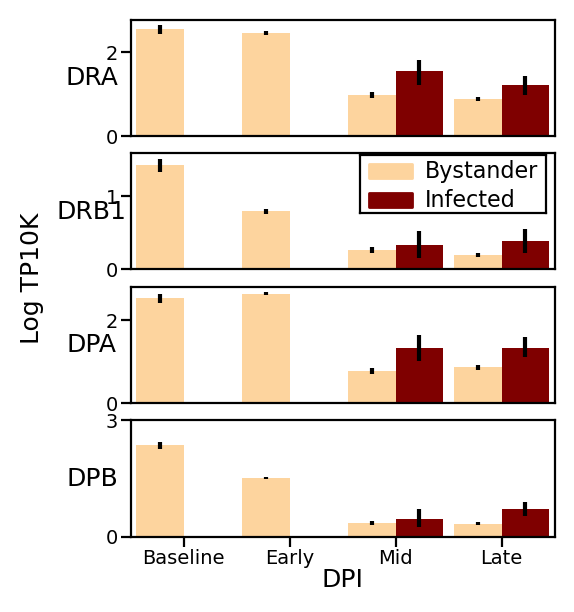

In [135]:
bar_height=.75
bar_width=2.3
genelab_width=.6
left_space = .02
right_space = .98
bottom_space = .1
top_space = .98
wspace_frac = 0
wspace = wspace_frac*np.mean([bar_width, genelab_width])
hspace_frac = 0.15
hspace = hspace_frac*bar_height
genelabelfontsize = 9

genes = ['MAMU-DRA', 'MAMU-DRB1', 'MAMU-DPA', 'MAMU-DPB']
ngenes = len(genes)
periods = ['Baseline', 'Early', 'Mid', 'Late']
nperiods = len(periods)
xlim = [-.5, nperiods-.5]

infected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[-1]
uninfected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[2] 


fig_width = (bar_width+genelab_width+wspace)*(right_space-left_space)
fig_height = (bar_height*ngenes + hspace*(ngenes-1))*(top_space-bottom_space)
genelabelfontsize
print(fig_width, fig_height)

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(
        nrows=ngenes,
        ncols=2,
        wspace=wspace_frac,
        hspace=hspace_frac,
        height_ratios=[bar_height]*ngenes, 
        width_ratios=[genelab_width, bar_width],
        left=left_space, right=right_space,
        bottom=bottom_space, top=top_space)

bar_axes = []
genelabel_axes = []
barwidth = .45
xpos = []
barcolor = []
labels = []
group_dist = .1
for i in range(nperiods):
    xpos += [i-barwidth, i]
    barcolor += [uninfected_color, infected_color]
    labels += ['Byst.', 'Inf.']

yticks = {'MAMU-DRA':[0,3], 'MAMU-DRB1':[0,2], 'MAMU-DPA':[0,3], 'MAMU-DPB':[0,2]}
for (i,g) in enumerate(genes):
    if i != (ngenes-1):
        bar_axes.append(fig.add_subplot(gs[i,1], xticks=[],
                                    xlim=xlim, frameon=True))
    else:
        bar_axes.append(fig.add_subplot(gs[i,1], xticks=np.arange(nperiods),
                                xticklabels=periods,
                                xlim=xlim, frameon=True))
    
    genelabel_axes.append(fig.add_subplot(gs[i,0], xticks=[], yticks=[],
                                  ylim=[0,1], xlim=[0,1], frameon=False))
    lab = g.split('-')[1]
    genelabel_axes[i].text(.65,.5,lab,va='center',ha='center',
                         fontsize=genelabelfontsize)
  
    height = mean_vals_full[g]
    yerr = pd.concat([height - lower_full[g], upper_full[g]-height], axis=1).T.values
    #yerr = pd.concat([lower[g], upper[g]], axis=1).T.values
   
    bar_axes[i].bar(xpos, height, width=barwidth, align='edge',
                  yerr=yerr, color=barcolor)
    bar_axes[i].grid(False)
  
    #maxv = upper[g].max()*1.05
    #bar_axes[i].set_ylim([0, maxv])
    #bar_axes[i].set_yticks(yticks[g])

bar_axes[-1].set_xlabel('DPI', labelpad=0)
bar_axes[-1].set_yticks([0,3])

leg_axes = fig.add_axes([.63, .65,.335, .1], xticks=[], yticks=[], xlim=[0,1],
                        ylim=[0,1])

leg_axes.fill_between([.05, .28], [.6,.6], [.85,.85],
                    color=uninfected_color)
leg_axes.text(.35, .72, 'Bystander', fontsize=8, va='center', ha='left')    

leg_axes.fill_between([.05, .28], [.11,.11], [.35,.35],
                    color=infected_color)
leg_axes.text(.35, .22, 'Infected', fontsize=8, va='center', ha='left')   

left_label_ax = fig.add_subplot(gs[:,0], xticks=[], yticks=[],
                                  ylim=[0,1], xlim=[0,1], frameon=False)
left_label_ax.text(0,.5,'Log TP10K', rotation=90, fontsize=9, ha='left', va='center')

figure_file = os.path.join(results_dir, "MHCcomparison.InfVsBys.Barplot.pdf")
fig.savefig(figure_file, dpi=200)

In [136]:
expr_mono.head()

index,MAMU-DPA,MAMU-DPB,MAMU-DRA,MAMU-DRB1,MAMU-DQA1,HLA-DQA1,HLA-DQB1,MAMU-A,MAMU-A3,MAMU-B,...,ZFP36,CIITA,Period,Subclustering_clean,DPIc,Ebola_Positive,percent_EBOV,ifn_score,Log10_EBOV_TPM,MX1
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG,3.131914,1.868636,2.858672,1.868636,0.000000,0.000000,0.000000,0.000000,0.000000,2.481476,...,2.481476,0.000000,Baseline,Mono,0,False,0.0,-0.251889,0.0,0.000000
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AACATATCACCC,2.016291,2.016291,0.000000,2.016291,0.000000,0.000000,2.016291,3.021948,2.016291,3.021948,...,3.297379,0.000000,Baseline,Mono,0,False,0.0,-0.313148,0.0,0.000000
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AACTGACCCCCT,2.502833,3.545331,2.502833,2.880634,0.000000,0.000000,0.000000,2.502833,0.000000,3.368765,...,0.000000,0.000000,Baseline,Mono,0,False,0.0,0.182212,0.0,2.502833
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_ACAACCCGCCGG,3.590186,3.740387,4.802591,4.359195,2.725506,3.566761,1.797477,2.968334,1.647761,3.905318,...,3.613075,0.609258,Baseline,Mono,0,False,0.0,-0.081322,0.0,0.985120
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AGCACTCTCGGG,3.845169,3.173179,0.000000,0.000000,0.000000,0.000000,0.000000,3.845169,0.000000,4.748547,...,3.173179,0.000000,Baseline,Mono,0,False,0.0,0.172875,0.0,3.173179


## ISG vs. EBOV plots

In [137]:
box_height=2.0
box_width=2.2
left_space = .15
right_space = .98
bottom_space = .13
top_space = .99

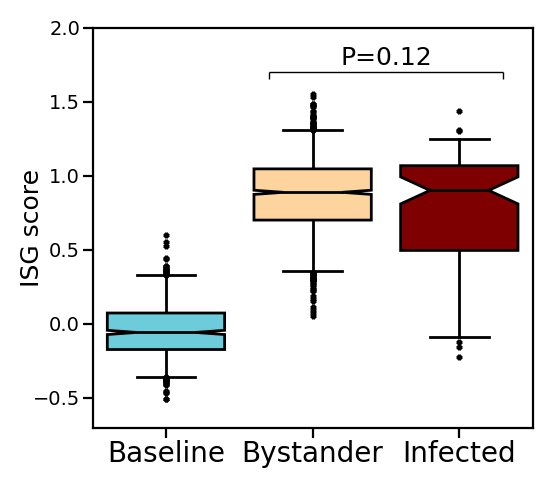

In [337]:
colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
dpimap = dict(zip(list(range(9)), colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap[0] = palettable.tableau.TableauMedium_10.mpl_colors[-1]
periodmap = {'Baseline':dpimap[0], 'Early':dpimap[3], 'Mid':dpimap[5], 'Late':dpimap[8]}
infected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[-1]
uninfected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[2] 

baseline_ind = expr_mono['DPIc']=='0'
not_infected_ind = expr_mono.index[(expr_mono['percent_EBOV']==0) & expr_mono['DPIc'].isin([  '6', '7', '8'])]
infected_ind = expr_mono.index[(expr_mono['Ebola_Positive'] == True) & expr_mono['DPIc'].isin([  '6', '7', '8'])]

bystander = list(expr_mono.loc[not_infected_ind, 'ifn_score'])
baseline = list(expr_mono.loc[baseline_ind, 'ifn_score'])
infected = list(expr_mono.loc[infected_ind, 'ifn_score'])

box_widths = .8
base_pos = -1.5
bys_pos = -.3
ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(1, 1, fig,
                       left_space, bottom_space, right_space,top_space)

box_ax = fig.add_subplot(gs[0], xlim=[-.5, 2.5],
                     ylabel='', xlabel='',
                     title='')

box_ax.set_ylabel('ISG score', labelpad=-4)

bplot = box_ax.boxplot([baseline, bystander, infected], positions=[0, 1, 2],
                   widths=box_widths, patch_artist=True, notch=True,
                  whis=[2.5,97.5],
                    medianprops=dict(color='k'),

                   flierprops=dict(color='k', markersize=1, marker='X'))



colors = [dpimap[0], uninfected_color, infected_color]
for (i,patch) in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i])

box_ax.set_xticklabels(['Baseline', 'Bystander', 'Infected'], fontsize=10)


from scipy.stats import ranksums
(H,P) = ranksums(bystander, infected)
bar_top = 1.7
verdist = .05
box_ax.hlines(y=bar_top, xmin=.7, xmax=2.3, linewidth=.5)
box_ax.vlines(x=.7, ymin=bar_top-verdist, ymax=bar_top, linewidth=.5)
box_ax.vlines(x=2.3, ymin=bar_top-verdist, ymax=bar_top, linewidth=.5)
box_ax.set_ylim([-.7,2.])

box_ax.text(1.5, bar_top+verdist, 'P=%.2f' % P, fontsize=9,ha='center')
box_ax.grid(False)

figure_file = os.path.join(results_dir, "IFNscore.Invivo.BaselineVSinfected.Box.pdf")
fig.savefig(figure_file, dpi=200)

2.0443926758312247e-05


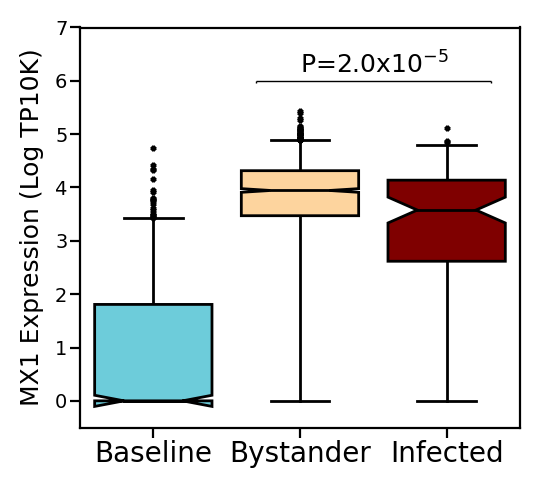

In [340]:
colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
dpimap = dict(zip(list(range(9)), colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap[0] = palettable.tableau.TableauMedium_10.mpl_colors[-1]
periodmap = {'Baseline':dpimap[0], 'Early':dpimap[3], 'Mid':dpimap[5], 'Late':dpimap[8]}
infected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[-1]
uninfected_color = palettable.colorbrewer.sequential.OrRd_9.mpl_colors[2] 


baseline_ind = expr_mono['DPIc']=='0'
tpm = np.log10(expr_mono['percent_EBOV']*100000+1)
not_infected_ind = (tpm==0) & expr_mono['DPIc'].isin([ '6', '7', '8'])
bystander = list(expr_mono.loc[not_infected_ind, 'MX1'])
baseline = list(expr_mono.loc[baseline_ind, 'MX1'])
infected = list(expr_mono.loc[infected_ind, 'MX1'])

box_widths = .8

base_pos = -1.5
bys_pos = -.3

ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(1, 1, fig,
                       left_space, bottom_space, right_space,top_space)

box_ax = fig.add_subplot(gs[0], xlim=[-.5, 2.5],
                     ylabel='', xlabel='',
                     title='')

box_ax.set_ylabel('MX1 Expression (Log TP10K)')

bplot = box_ax.boxplot([baseline, bystander, infected], positions=[0, 1, 2],
                   widths=box_widths, patch_artist=True, notch=True,
                  whis=[2.5,97.5],
                    medianprops=dict(color='k'),

                   flierprops=dict(color='k', markersize=1, marker='X'))



colors = [dpimap[0], uninfected_color, infected_color]
for (i,patch) in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i])

box_ax.set_xticklabels(['Baseline', 'Bystander', 'Infected'], fontsize=10)
box_ax.set_ylim([-.5,7])

bar_top = 6
verdist = .05
box_ax.hlines(y=bar_top, xmin=.7, xmax=2.3, linewidth=.5)
box_ax.vlines(x=.7, ymin=bar_top-verdist, ymax=bar_top, linewidth=.5)
box_ax.vlines(x=2.3, ymin=bar_top-verdist, ymax=bar_top, linewidth=.5)


from scipy.stats import ranksums
(H,P) = ranksums(bystander, infected)

print(P)
box_ax.text(1., 6.13, 'P=2.0x$10^{-5}$' % P, fontsize=9)
box_ax.grid(False)

figure_file = os.path.join(results_dir, "MX1.Invivo.BaselineVSinfected.Box.pdf")
fig.savefig(figure_file, dpi=200)

1.1043463732936641e-11


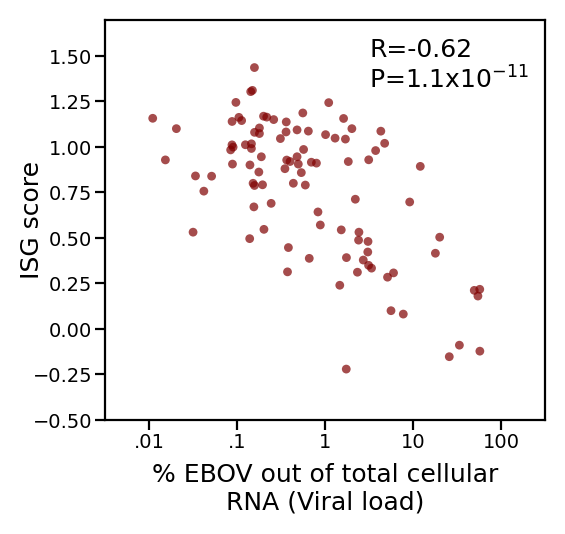

In [343]:
left_space=.2
bottom_space = .2
ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(1, 1, fig,
                       left_space, bottom_space, right_space,top_space)

scatter_ax = fig.add_subplot(gs[0],
                      xlabel='% EBOV out of total cellular\nRNA (Viral load)',
                     title='', ylabel='')
scatter_ax.set_ylabel('ISG score', labelpad=-4)

scatter_ax.scatter(np.log10(expr_mono.loc[infected_ind, 'percent_EBOV']*100000+1),
                   expr_mono.loc[infected_ind, 'ifn_score'], s=10,
                   color=[0.49803922, 0.        , 0.    , .7    ],
                   edgecolor='None')

scatter_ax.tick_params(labelsize=7)


scatter_ax.set_xlim([.5,5.5])
scatter_ax.set_xticks([1, 2, 3, 4, 5])
scatter_ax.set_xticklabels([ '.01', '.1', '1', '10', '100'])

from scipy.stats import pearsonr
(R,P) = pearsonr(np.log10(expr_mono.loc[infected_ind, 'percent_EBOV']*100000+1),
                 expr_mono.loc[infected_ind, 'ifn_score'])
print(P)
scatter_ax.text(3.5, 1.6, 'R=%.2f\nP=1.1x10$^{-11}$' % (R), fontsize=9, va='top')
scatter_ax.set_ylim([-.5,1.7])
scatter_ax.grid(False)

figure_file = os.path.join(results_dir, "IFNscore.Invivo.BaselineVSinfected.Scatter.pdf")
fig.savefig(figure_file, dpi=200)

## Per cell-type stage gene-set testing

In [141]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres = pd.read_csv(mergefn, header=[0,1,2], index_col=0)
allres.head()

Th                                                           \
          Early                                                            
          logFC       P_H      logP         Q      logQ logFC_unadjusted   
AAAS  -0.024369  0.204801  0.688668  0.532614  0.273587        -0.036496   
AACS  -0.053778  0.012804  1.892639  0.086007  1.065468        -0.044429   
AAK1  -0.083330  0.000876  3.057295  0.010117  1.994949        -0.137175   
AAMDC -0.002159  0.960256  0.017613  1.000000 -0.000000        -0.005367   
AAMP  -0.026134  0.261689  0.582215  0.615723  0.210615        -0.075213   

                                                    ...  cDC                   \
                           Mid                      ...  Mid                    
      logFC_combined     logFC       P_H      logP  ... logQ logFC_unadjusted   
AAAS       -0.024369 -0.035796  0.236104  0.626896  ... -0.0         0.028769   
AACS       -0.053778 -0.040785  0.234790  0.629321  ... -0.0         0.071784   
AAK1       -0.083330 -0.101726  0.000549  3.260209  ... -0.0         0.083262   
AAMDC      -0.002159 -0.007186  0.922546  0.035012  ... -0.0         0.021262   
AAMP       -0.026134 -0.069048  0.046581  1.331788  ... -0.0         0.025387   

                                                                               \
                          Late                                                  
      logFC_combined     logFC       P_H      logP    Q logQ logFC_unadjusted   
AAAS        0.028769       NaN  0.804712  0.094360  1.0 -0.0         0.015157   
AACS        0.071784  0.002324  0.841318  0.075040  1.0 -0.0         0.022465   
AAK1        0.083262       NaN       NaN       NaN  NaN  NaN              NaN   
AAMDC       0.021262  0.024100  0.458490  0.338670  1.0 -0.0         0.037021   
AAMP       -0.139541  0.087060  0.872437  0.059266  1.0 -0.0        -0.025007   

                      
                      
      logFC_combined  
AAAS        0.015157  
AACS        0.002324  
AAK1             NaN  
AAMDC       0.024100  
AAMP        0.087060  

[5 rows x 168 columns]

In [582]:
from geneset_testing import ranksumtestbygep

In [583]:
continuous_fc = allres.xs('logFC', axis=1, level=2).drop('Neut', axis=1, level=0)
tested_genes = (~continuous_fc.isnull()).sum(axis=1) > 0
continuous_fc = continuous_fc.loc[tested_genes, :]

gset_hallmark, gset_hallmark_genes = load_geneset(hallmark_gsetfn,  genes=list(continuous_fc.index), minsize=10)
gset_hallmark['IFN_ALPHA-GAMMA'] = gset_hallmark['HALLMARK_INTERFERON_ALPHA_RESPONSE'] - gset_hallmark['HALLMARK_INTERFERON_GAMMA_RESPONSE']
gset_hallmark['IFN_GAMMA-ALPHA'] = gset_hallmark['HALLMARK_INTERFERON_GAMMA_RESPONSE'] - gset_hallmark['HALLMARK_INTERFERON_ALPHA_RESPONSE']

continuous_fc[continuous_fc.isnull()]=0
continuous_fc_totest = continuous_fc.loc[gset_hallmark_genes, :]


hallmark_mw = ranksumtestbygep(gset_hallmark, continuous_fc_totest)


0 out of 52


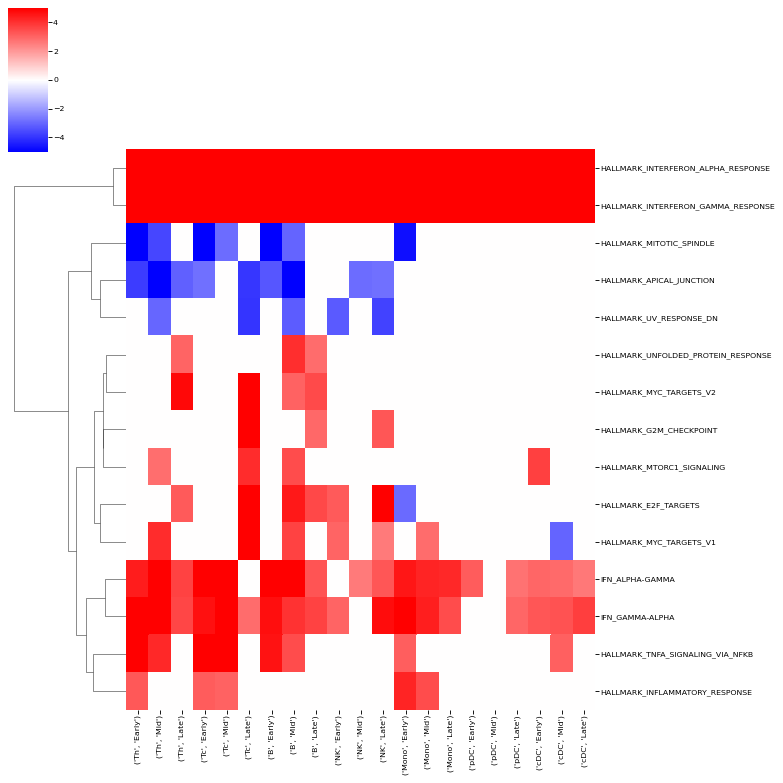

In [584]:
hallmark_H = hallmark_mw.xs('H', axis=1, level=1).astype(float)
hallmark_P = hallmark_mw.xs('P', axis=1, level=1).astype(float)
hallmark_H[hallmark_P>.01] = 0

ind = (hallmark_P<.0001).sum(axis=1)>0

order =['HALLMARK_INTERFERON_ALPHA_RESPONSE',
 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
 'IFN_ALPHA-GAMMA',
 'IFN_GAMMA-ALPHA',
 'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
 'HALLMARK_INFLAMMATORY_RESPONSE',
'HALLMARK_ALLOGRAFT_REJECTION',
 'HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY',
 'HALLMARK_MITOTIC_SPINDLE',
 'HALLMARK_MYOGENESIS',
 'HALLMARK_APICAL_JUNCTION',
]

thresh = 5

resv = sns.clustermap(hallmark_H.loc[ind,:], yticklabels=True, cmap='bwr', col_cluster=False,  vmin=-1*thresh, vmax=thresh)

0 1
1 4
2 7
3 10
4 13


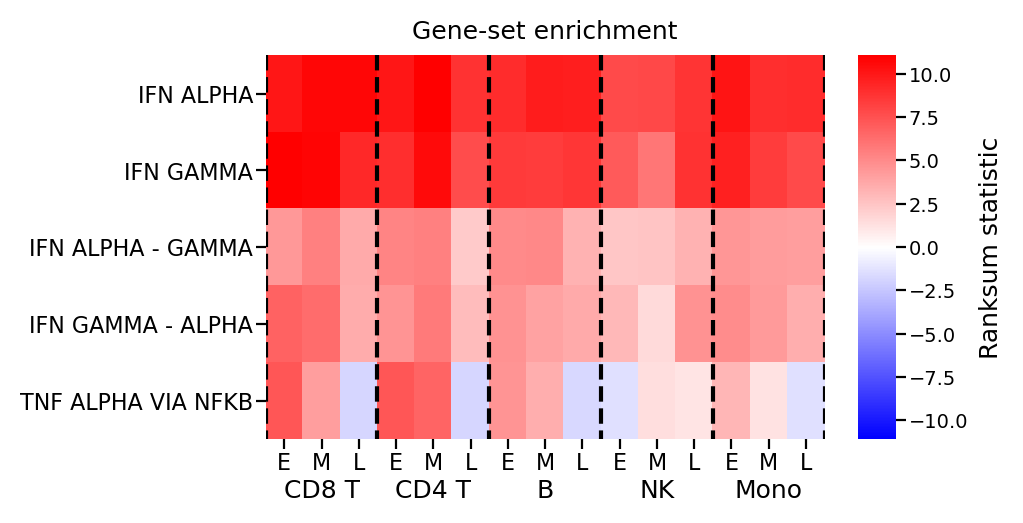

In [587]:
order =['HALLMARK_INTERFERON_ALPHA_RESPONSE',
 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
 'IFN_ALPHA-GAMMA',
 'IFN_GAMMA-ALPHA',
 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'
]

hallmark_H = hallmark_mw.xs('H', axis=1, level=1).astype(float)
hallmark_P = hallmark_mw.xs('P', axis=1, level=1).astype(float)


fig = plt.figure(constrained_layout=True, figsize=(5.0, 2.5), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.9,
                       wspace=.001)
ax = fig.add_subplot(gs[0], title='Gene-set enrichment')
#cbar_ax = fig.add_subplot(gs[1], title='Standardized\nU')


hallmark_H_toplot = hallmark_H.loc[order,:]
hallmark_H_toplot.index = ['IFN ALPHA', 'IFN GAMMA', 'IFN ALPHA - GAMMA', 'IFN GAMMA - ALPHA', 'TNF ALPHA VIA NFKB']
cols = [x for x in hallmark_H_toplot.columns if x[0] not in ['pDC', 'cDC']]
hallmark_H_toplot = hallmark_H_toplot.loc[:, cols]
thresh = hallmark_H_toplot.abs().max().max()

sns.heatmap(hallmark_H_toplot, yticklabels=True, cmap='bwr', vmin=-1*thresh, vmax=thresh,
            ax=ax, cbar_kws={'label':'Ranksum statistic'}, linewidths=0, linecolor='k')
for i in range(0,25,3):
    ax.vlines(x=i, ymin=0, ymax=hallmark_H_toplot.shape[0], linestyle='--')
ax.set_yticklabels(hallmark_H_toplot.index, fontsize=8)
ax.set_xticks(np.arange(0, hallmark_H_toplot.shape[1])+.5)
xticklabels = ['E', 'M', 'L']*5
ctorder = ['CD8 T', 'CD4 T', 'B', 'NK', 'Mono']

ax.set_xticklabels(xticklabels, fontsize=8, rotation=0)
ax.set_xlabel('')

for (i,xpos) in enumerate(range(1,16,3)):
    print(i, xpos)
    ax.text(xpos+.5, 5.68, ctorder[i], fontsize=9, va='center', ha='center')

figure_file = os.path.join(results_dir, "IFNalphaVsgamma.EnrichCompare.InvivoSeqwell.Heatmap.pdf")
fig.savefig(figure_file, dpi=200)

## Specifically analyze cytokines

In [181]:
go_gset_fn = '../../../../data/Genesets/msigdb/c5.all.v6.2.symbols.gmt'

In [182]:
(go_genesets, go_genes) = load_geneset(go_gset_fn,  minsize=10)

In [183]:
go_cytokines = go_genesets['GO_CYTOKINE_ACTIVITY']

In [184]:
adata_cytokine = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)

In [185]:
sc.pp.filter_genes(adata_cytokine, min_cells=10)

filtered out 241 genes that are detectedin less than 10 cells


In [186]:
adata_cytokine = adata_cytokine[:, ~adata_cytokine.var['Combined_Blacklist']]

In [187]:
sc.pp.normalize_per_cell(adata_cytokine, counts_per_cell_after=10000)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [188]:
sc.pp.log1p(adata_cytokine)

In [189]:
gene_info = adata_cytokine.var.copy()
ind = gene_info['gene_symbol'].isin(go_cytokines) | gene_info['human_ortholog_name'].isin(go_cytokines)
cytokine_geneinfo = gene_info.loc[ind, :]
cytokine_geneinfo['Cytokine_Name'] = np.nan
ind = ~cytokine_geneinfo['gene_symbol'].isin(go_cytokines) & cytokine_geneinfo['human_ortholog_name'].isin(go_cytokines)
cytokine_geneinfo.loc[ind, 'Cytokine_Name'] = cytokine_geneinfo.loc[ind, 'human_ortholog_name']

ind = cytokine_geneinfo['gene_symbol'].isin(go_cytokines) 
cytokine_geneinfo.loc[ind, 'Cytokine_Name'] = cytokine_geneinfo.loc[ind, 'gene_symbol']
cytokine_geneinfo.head()

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,full_id,gene_symbol,gene_id,human_ortholog_id,human_ortholog_name,human_ortholog_type,human_ortholog_percent_identity,human_ortholog_percent_confidence,merged_symbol,n_cells,Combined_Blacklist,EBOV_Blacklist,Mito_Blacklist,Ribo_Blacklist,CC_Blacklist,Cytokine_Name
index,,,,,,,,,,,,,,,,
CMTM2,ENSMMUG00000000032__CMTM2,CMTM2,ENSMMUG00000000032,ENSG00000140932,CMTM2,ortholog_one2one,79.8387,1.0,CMTM2,178,False,False,False,False,False,CMTM2
CCL28,ENSMMUG00000000179__CCL28,CCL28,ENSMMUG00000000179,ENSG00000151882,CCL28,ortholog_one2one,96.0630,1.0,CCL28,26,False,False,False,False,False,CCL28
NRG1,ENSMMUG00000000208__NRG1,NRG1,ENSMMUG00000000208,ENSG00000157168,NRG1,ortholog_one2one,75.5039,1.0,NRG1,836,False,False,False,False,False,NRG1
CCL2,ENSMMUG00000000288__CCL2,CCL2,ENSMMUG00000000288,ENSG00000108691,CCL2,ortholog_one2one,96.9697,1.0,CCL2,453,False,False,False,False,False,CCL2
CX3CL1,ENSMMUG00000000426__CX3CL1,CX3CL1,ENSMMUG00000000426,nan,nan,nan,NaN,NaN,CX3CL1,12,False,False,False,False,False,CX3CL1


In [190]:
X = pd.DataFrame(adata_cytokine.X.todense(), index=adata_cytokine.obs.index, columns=adata_cytokine.var.index)

In [191]:
X_cytokine = X.loc[:,cytokine_geneinfo.index]

In [192]:
X_cytokine['Subclustering_reduced'] = adata_cytokine.obs['Subclustering_reduced']
X_cytokine['Period'] = adata_cytokine.obs['Period']

In [193]:
X_cytokine

index,CMTM2,CCL28,NRG1,CCL2,CX3CL1,BMP4,PF4V1,CMTM6,IL7,GREM1,...,TNLG1F,HMGB1,IFNE,CCL18,WNT2,IL5,CXCL2,LIF,Subclustering_reduced,Period
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACAAGACTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,B,Baseline
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACACGCTTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.439243,0.0,0.0,...,0.0,2.365796,0.0,0.0,0.0,0.0,0.0,0.0,Th,Baseline
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACGAGATTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,2.908595,0.0,0.0,0.0,0.0,0.0,0.0,B,Baseline
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868636,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Mono,Baseline
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAATCGCTCCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.394982,0.0,0.0,...,0.0,1.394982,0.0,0.0,0.0,0.0,0.0,0.0,Tc,Baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTGTAACCGGGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Neut,Early
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTGTTGGGCGCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.990900,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Mono,Early
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTTAAATGCGGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,3.327971,0.0,0.0,0.0,0.0,0.0,0.0,Th,Early
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTTCTTGCTCTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Neut,Early


In [194]:
#averaging by group
average = X_cytokine.groupby(['Subclustering_reduced', 'Period']).mean()
count = X_cytokine.groupby(['Subclustering_reduced', 'Period']).agg(lambda x: (x>0).sum())


In [195]:
count.head()

CMTM2  CCL28  NRG1  CCL2  CX3CL1  BMP4  PF4V1  \
Subclustering_reduced Period                                                    
B                     Baseline    0.0    0.0   6.0   1.0     0.0   1.0   14.0   
                      Early       0.0    0.0   9.0   0.0     1.0   4.0    2.0   
                      Late        2.0    0.0  21.0   1.0     0.0   4.0    7.0   
                      Mid         1.0    1.0   4.0   0.0     0.0   1.0    2.0   
Mono                  Baseline    1.0    0.0  21.0   2.0     1.0   1.0   19.0   

                                 CMTM6   IL7  GREM1  ...  GDF6  IL27  TNLG1F  \
Subclustering_reduced Period                         ...                       
B                     Baseline   602.0  69.0    1.0  ...   1.0   0.0     4.0   
                      Early     1110.0  89.0    3.0  ...   0.0   0.0    11.0   
                      Late      1537.0  77.0    4.0  ...   1.0   1.0    10.0   
                      Mid       1003.0  61.0    0.0  ...   0.0   0.0    12.0   
Mono                  Baseline   279.0   3.0    0.0  ...   0.0   0.0     8.0   

                                HMGB1  IFNE  CCL18  WNT2  IL5  CXCL2  LIF  
Subclustering_reduced Period                                               
B                     Baseline  453.0   1.0    0.0   3.0  0.0    1.0  1.0  
                      Early     547.0   0.0    0.0   2.0  0.0    0.0  1.0  
                      Late      883.0   2.0    0.0   1.0  5.0    1.0  2.0  
                      Mid       518.0   2.0    0.0   0.0  1.0    0.0  1.0  
Mono                  Baseline  213.0   0.0    1.0   0.0  0.0    8.0  0.0  

[5 rows x 122 columns]

In [196]:
adata_cytokine = adata_cytokine[:, cytokine_geneinfo.index]

In [197]:
dedir = os.path.join(adir, 'DE_Stage_Cytokine')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [198]:
adata_cytokine.obs['is_fresh'] = adata_cytokine.obs['frz_status'].replace({'fresh':1, 'FRZ':0})

Trying to set attribute `.obs` of view, copying.


In [199]:
from sklearn.preprocessing import scale
cts = ['Th', 'Tc', 'B', 'NK', 'Mono']
test_periods = ['Early', 'Mid', 'Late']

for ct in cts:
    for test_period in test_periods:
        ind = (adata_cytokine.obs['Subclustering_reduced']==ct) & (adata_cytokine.obs['Period'].isin(['Baseline', test_period]))
        adata_ct = adata_cytokine[ind,:]
        sc.pp.filter_genes(adata_ct, min_cells=10)
        print(adata_ct.shape)
        
        
        
        adata_ct.obs['Period_Binary'] = adata_ct.obs['Period'].replace({'Baseline':0, test_period:1})
        adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
        adata_ct.obs['soup_usage_scale'] = scale(adata_ct.obs['Soup_Usage'])
        adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])        
        adata_ct.obs['cngeneson'] =  scale((adata_ct.X>0).sum(axis=1)).reshape(-1)                
        X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
        X.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.cytokineOnly.expression.csv'))
        adata_ct.obs.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.cytokineOnly.celldata.csv'))
        adata_ct.var.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.cytokineOnly.genedata.csv'))

filtered out 65 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(7468, 57)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 65 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(6238, 57)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 58 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(10178, 64)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 69 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(4096, 53)
filtered out 72 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(4428, 50)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 67 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(5624, 55)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 69 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(4799, 53)
filtered out 69 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(4639, 53)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 66 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(7969, 56)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 90 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(700, 32)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 90 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(724, 32)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 84 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(974, 38)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 59 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(4339, 63)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 64 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(1743, 58)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


filtered out 61 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


(2366, 61)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [200]:
ncores =4
testvar = 'Period_Binary'
covars = ['is_fresh_scale', 'cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

for ct in cts:
    for test_period in test_periods:
        exprfn = os.path.join(de_infiles, ct+'.'+test_period+'.cytokineOnly.expression.csv')
        celldatfn = os.path.join(de_infiles, ct+'.'+test_period+'.cytokineOnly.celldata.csv')
        genedatfn = os.path.join(de_infiles, ct+'.'+test_period+'.cytokineOnly.genedata.csv')
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.cytokineOnly.DE.csv')
        cmd = 'Rscript ../../../Code/run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
        print(cmd)
        !{cmd}

Rscript ../../../Code/run_mast.R ../../../../data/InVivo/Seqwell/DE_Stage_Cytokine/genefiles/Th.Early.cytokineOnly.expression.csv ../../../../data/InVivo/Seqwell/DE_Stage_Cytokine/genefiles/Th.Early.cytokineOnly.celldata.csv ../../../../data/InVivo/Seqwell/DE_Stage_Cytokine/genefiles/Th.Early.cytokineOnly.genedata.csv ../../../../data/InVivo/Seqwell/DE_Stage_Cytokine/results/Th.Early.cytokineOnly.DE.csv 4 Period_Binary is_fresh_scale,cngeneson,percent_mito_scale
~Period_Binary + is_fresh_scale + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [==========>---------------------------------]  25% with 0 failures


In [201]:
allres_cytokine = []

cts = ['Th', 'Tc', 'B', 'NK', 'Mono']
test_periods = ['Early', 'Mid', 'Late']

for ct in cts:
    for test_period in test_periods:
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.cytokineOnly.DE.csv')
        res = pd.read_csv(resultsfn)
        res.index = res['primerid']
        res.drop(['P_C', 'P_D'], axis=1, inplace=True)
        res.columns = [(ct, test_period, x) for x in res.columns]
        allres_cytokine.append(res)
        
allres_cytokine = pd.concat(allres_cytokine, axis=1)
allres_cytokine.columns = pd.MultiIndex.from_tuples(allres_cytokine.columns)

In [202]:
allres_cytokine_P = allres_cytokine.xs('P_H', axis=1, level=2)
allres_cytokine_FC = allres_cytokine.xs('logFC', axis=1, level=2)

In [203]:
pass_thresh = (allres_cytokine_P<.05) & (allres_cytokine_FC.abs()>np.log(FC_thresh))
num_pass_thresh = pass_thresh.sum(axis=1)
passes = num_pass_thresh.index[num_pass_thresh>0]
passes

Index(['CKLF', 'CMTM3', 'CMTM6', 'CSF1', 'ENSMMUG00000005880',
       'ENSMMUG00000042343', 'FAM3C', 'GRN', 'HMGB1', 'IL16', 'IL1B', 'LTB',
       'NAMPT', 'OSM', 'SP100', 'TNFSF10', 'TNFSF12', 'TNFSF13B', 'VEGFA',
       'CXCL16', 'IL1RN'],
      dtype='object')

In [204]:
adata.var.loc['ENSMMUG00000005880', :]

full_id                              ENSMMUG00000005880__ENSMMUG00000005880
gene_symbol                                              ENSMMUG00000005880
gene_id                                                  ENSMMUG00000005880
human_ortholog_id                                           ENSG00000105220
human_ortholog_name                                                     GPI
human_ortholog_type                                       ortholog_one2many
human_ortholog_percent_identity                                     94.6399
human_ortholog_percent_confidence                                         1
merged_symbol                                                           GPI
n_cells                                                                8192
Combined_Blacklist                                                    False
EBOV_Blacklist                                                        False
Mito_Blacklist                                                        False
Ribo_Blackli

In [205]:
cytokines_to_plot = list(passes) + ['IFNA2', 'IFNA8', 'IFNB1', 'IFNG', 'IL6']
cytokines_to_plot = list(set(cytokines_to_plot) - {'SP100', 'CMTM6', 'HMGB1'})

In [206]:
len(cytokines_to_plot)

23

In [207]:
ind = []
for ct in ['Mono', 'B', 'Tc', 'Th', 'NK']:
    for tp in ['Baseline', 'Early', 'Mid', 'Late']:
        ind.append((ct, tp))
        


average_toplot = average.loc[ind, cytokines_to_plot]

In [208]:
average_toplot.rename(columns={'ENSMMUG00000042343':'CCL3L3', 'ENSMMUG00000005880':'GPI'}, inplace=True)

In [209]:
allres_cytokine.rename(index={'ENSMMUG00000042343':'CCL3L3', 'ENSMMUG00000005880':'GPI'}, inplace=True)

0 2
1 6
2 10
3 14
4 18
../../../../results/CytokineHeatmap.Invivo.MaxNorm.Heatmap.pdf


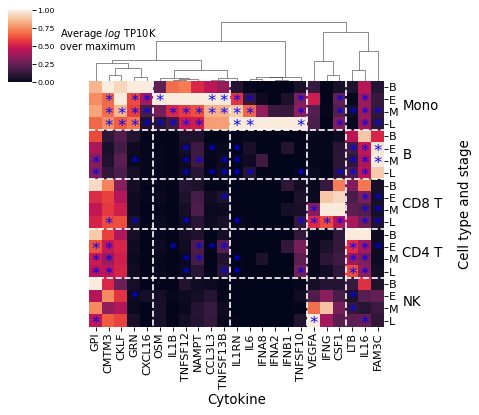

In [283]:
average_stdnorm = average_toplot.div(average_toplot.max(axis=0), axis=1)

D = pdist(average_stdnorm.T, metric='correlation')
Z = linkage(D, method='ward')
Z = optimal_leaf_ordering(Z, D)

res = sns.clustermap(average_stdnorm, row_cluster=False, col_linkage=Z, figsize=(6,5))
res.ax_heatmap.set_ylabel('')
xticklabels = average_stdnorm.columns[res.dendrogram_col.reordered_ind]

for j,g in enumerate(xticklabels):
    for i,(ct, period) in enumerate(average_stdnorm.index):
        if period != 'Baseline':
            if g in allres_cytokine.index:
                P = allres_cytokine.loc[g, (ct, period, 'P_H')]
                if P < .05:
                    res.ax_heatmap.text(j+.5, i+.7, '*', c='b', va='center', ha='center', fontsize=15)


yticklabels = ['B      ', 'E      ', 'M      ', 'L                  ']*5
res.ax_heatmap.set_yticklabels(yticklabels, fontsize=10)
res.ax_heatmap.set_xticklabels(xticklabels, fontsize=10)

ctorder = ['Mono', 'B', 'CD8 T', 'CD4 T', 'NK']
for (i,ypos) in enumerate(range(2,20,4)):
    print(i, ypos)
    res.ax_heatmap.text(average_stdnorm.shape[1]+1.4, ypos, ctorder[i], fontsize=12,
                       ha='left', va='center')


res.ax_heatmap.text(-2.3, -2.5, 'Average $log$ TP10K \nover maximum', fontsize=9)

for i in range(4, average_stdnorm.shape[0], 4):
    res.ax_heatmap.hlines(i, 0, average_stdnorm.shape[1], linestyle='--', color='w')


#for x in [1,2,4,9,10, 17, 18]:
for x in [5, 11,  17, 20]:
    res.ax_heatmap.vlines(x, 0, average_stdnorm.shape[0], linestyle='--', color='w')

res.ax_heatmap.set_ylabel('Cell type and stage', fontsize=12, labelpad=-0.5)
res.ax_heatmap.set_xlabel('Cytokine', fontsize=12)

figure_file = os.path.join(results_dir, "CytokineHeatmap.Invivo.MaxNorm.Heatmap.pdf")
print(figure_file)
plt.savefig(figure_file, dpi=200, bbox_inches='tight')

In [298]:
adata_cytokine_mono_raw = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata_cytokine_mono_raw = adata_cytokine_mono_raw[adata_cytokine_mono_raw.obs['Subclustering_reduced']=='Mono',:]
sc.pp.filter_genes(adata_cytokine_mono_raw, min_cells=10)
sc.pp.normalize_per_cell(adata_cytokine_mono_raw, counts_per_cell_after=10000)

filtered out 5250 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [316]:
expr = pd.DataFrame(adata_cytokine_mono_raw.X.todense(), index=adata_cytokine_mono_raw.obs.index, columns=adata_cytokine_mono_raw.var.index)

In [317]:
expr[['IFNA2', 'IFNA8', 'IFNB1']].groupby(adata_cytokine_mono_raw.obs['Period']).mean().loc[['Baseline', 'Early', 'Mid', 'Late'], :]*100

index,IFNA2,IFNA8,IFNB1
Period,,,
Baseline,0.000000,0.000000,0.000000
Early,0.000000,0.125261,0.155412
Mid,0.313639,1.062144,0.300814
Late,5.018568,4.632336,2.937559


In [312]:
adata_cytokine_Tc_raw = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata_cytokine_Tc_raw = adata_cytokine_Tc_raw[adata_cytokine_Tc_raw.obs['Subclustering_reduced']=='Tc',:]
sc.pp.filter_genes(adata_cytokine_Tc_raw, min_cells=10)
sc.pp.normalize_per_cell(adata_cytokine_Tc_raw, counts_per_cell_after=10000)
expr = pd.DataFrame(adata_cytokine_Tc_raw.X.todense(), index=adata_cytokine_Tc_raw.obs.index, columns=adata_cytokine_Tc_raw.var.index)

filtered out 5064 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [314]:
expr[['IFNG']].groupby(adata_cytokine_Tc_raw.obs['Period']).mean().loc[['Baseline', 'Early', 'Mid', 'Late'], :]*100

index,IFNG
Period,
Baseline,40.720482
Early,433.215179
Mid,500.025848
Late,341.996033


In [292]:
pd.DataFrame(adata_cytokine_mono_raw.X.todense(), index=

AnnData object with n_obs × n_vars = 56929 × 17137 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced', 'Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blackli